# Differential Protein Expression Analysis

This notebook performs differential expression analysis on normalized proteomics data using mixed effects models.

**Analysis options:**
1. **Paired vs Unpaired**: Choose between paired (same subjects across conditions) or unpaired analysis
2. **Group Comparison**: Select two groups to compare
3. **Normalization Method**: Uses normalized data from the previous notebook
4. **Statistical Model**: Mixed effects model accounting for subject-level variation

**Output:**
- Volcano plots
- Statistical results tables
- Export files for downstream analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
%matplotlib inline

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [4]:
# Check available annotation columns in the processed data
print("=== CHECKING DATA AVAILABILITY ===\n")

# Check if processed_data exists from previous notebook runs
try:
    print("Available columns in processed_data:")
    print(f"Shape: {processed_data.shape}")
    print("\nColumns:")
    for i, col in enumerate(processed_data.columns):
        print(f"{i}: {col}")

    # Look for gene-related columns
    gene_cols = [col for col in processed_data.columns if any(keyword in col.lower() for keyword in ['gene', 'symbol', 'name', 'description'])]
    print(f"\nPotential gene annotation columns: {gene_cols}")

    # Show a sample of the data to understand the annotation structure
    print(f"\nSample of annotation data (first 3 rows):")
    annotation_cols = [col for col in processed_data.columns if col not in cleaned_sample_names]
    if annotation_cols:
        print(processed_data[annotation_cols[:5]].head(3).to_string())  # Show first 5 annotation columns
        
    print("\n✓ Processed data found in memory from previous notebook run!")
    
except NameError:
    print("Processed data not found in memory.")
    print("Running previous notebooks to load data...")
    
    # Import required modules for output suppression
    import warnings
    import matplotlib
    import matplotlib.pyplot as plt
    import sys
    from io import StringIO
    
    # Store current state
    original_backend = matplotlib.get_backend()
    original_interactive = matplotlib.is_interactive()
    
    # Completely suppress plotting and output during import
    matplotlib.use('Agg')  # Non-interactive backend
    plt.ioff()  # Turn off interactive mode
    plt.close('all')  # Close any existing figures
    
    # Capture and suppress all output
    old_stdout = sys.stdout
    old_stderr = sys.stderr
    
    try:
        # Redirect all output to suppress it
        sys.stdout = StringIO()
        sys.stderr = StringIO()
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            # Run both notebooks silently
            %run "1-import-skyline-output.ipynb"
            %run "2-normalize-data.ipynb"
    
    finally:
        # Restore original output streams
        sys.stdout = old_stdout
        sys.stderr = old_stderr
        
        # Clean up plots and restore matplotlib state
        plt.close('all')
        plt.clf()
        plt.cla()
        matplotlib.use(original_backend)
        if original_interactive:
            plt.ion()
        %matplotlib inline
    
    print("✓ Data successfully loaded from previous notebooks!")
    print(f"Processed data shape: {processed_data.shape}")
    print(f"Sample metadata available: {len(sample_metadata)} samples")

=== CHECKING DATA AVAILABILITY ===

Available columns in processed_data:
Shape: (3378, 54)

Columns:
0: Protein
1: UniProt_Accession
2: UniProt_Database
3: UniProt_Entry_Name
4: Gene
5: Description
6: A01-511-84A-C4-001
7: A02-Hoof17-002
8: A03-304-75B-B4-003
9: A04-450-08A-C7-004
10: A05-051-21B-D6-005
11: A06-510-08B-C8-006
12: A07-912-46A-A9-007
13: A08-492-84B-B8-008
14: A09-159-21A-D7-009
15: A10-990-46B-A8-010
16: A11-EISAIPool-011
17: A12-278-75A-B6-012
18: B01-041-40B-B1-013
19: B02-934-43A-A2-014
20: B03-959-40A-A5-015
21: B04-EISAIPool-016
22: B05-334-76A-B9-017
23: B06-GWPool-018
24: B07-168-16A-D3-019
25: B08-009-43B-A3-020
26: B09-316-76B-C3-021
27: B10-062-16B-D5-022
28: B11-Hoof17-023
29: B12-GWPool-024
30: C01-027-37B-B3-025
31: C02-907-45A-B2-026
32: C03-EISAIPool-027
33: C04-155-17A-D1-028
34: C05-166-20A-D8-029
35: C06-249-64B-B5-030
36: C07-985-45B-A1-031
37: C08-Hoof17-032
38: C09-956-37A-A6-033
39: C10-216-64A-C2-034
40: C11-056-20B-D9-035
41: C12-046-17B-C9-036
4

In [5]:
# Load normalized data (if not already available)
print("=== CHECKING NORMALIZED DATA ===\n")

# Check if normalized data already exists in memory
try:
    # Verify all required variables exist
    test_vars = [
        ('median_normalized_data', median_normalized_data),
        ('vsn_normalized_data', vsn_normalized_data), 
        ('sample_metadata', sample_metadata),
        ('group_counts', group_counts)
    ]
    
    print("Checking required variables...")
    for var_name, var_obj in test_vars:
        if var_name in ['median_normalized_data', 'vsn_normalized_data']:
            print(f"✓ {var_name}: shape {var_obj.shape}")
        elif var_name == 'sample_metadata':
            print(f"✓ {var_name}: {len(var_obj)} samples")
        elif var_name == 'group_counts':
            print(f"✓ {var_name}: groups {list(var_obj.index)}")
    
    print("\n✓ All normalized data found in memory from previous notebook run!")
    
except NameError as e:
    missing_var = str(e).split("'")[1]
    print(f"Normalized data variable '{missing_var}' not found in memory.")
    print("Running the normalization notebook to load data...")
    
    # Store current matplotlib backend and plotting state
    import matplotlib
    import matplotlib.pyplot as plt
    original_backend = matplotlib.get_backend()
    original_interactive = matplotlib.is_interactive()
    
    # Completely suppress all plotting during import
    matplotlib.use('Agg')  # Use non-interactive backend
    plt.ioff()  # Turn off interactive mode
    
    # Close any existing figures and clear memory
    plt.close('all')
    plt.clf()  # Clear current figure
    plt.cla()  # Clear current axes
    
    # Temporarily disable all warnings during import
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        # Run the normalization notebook to load all variables
        print(">>> Running normalization notebook...")
        %run "2-normalize-data.ipynb"
    
    # Close all figures created during import and clear memory
    plt.close('all')
    plt.clf()
    plt.cla()
    
    # Restore original plotting configuration
    matplotlib.use(original_backend)
    if original_interactive:
        plt.ion()  # Turn interactive mode back on only if it was on
    %matplotlib inline
    
    print(f"\n✓ Normalized data loaded successfully from normalization notebook!")
    print(f"Median normalized data shape: {median_normalized_data.shape}")
    print(f"VSN normalized data shape: {vsn_normalized_data.shape}")
    print(f"Sample metadata available: {len(sample_metadata)} samples")
    print(f"Available groups: {list(group_counts.index)}")

# Final verification
print(f"\nFinal data summary:")
print(f"• Processed data: {processed_data.shape}")
print(f"• Median normalized: {median_normalized_data.shape}")  
print(f"• VSN normalized: {vsn_normalized_data.shape}")
print(f"• Sample metadata: {len(sample_metadata)} samples")
print(f"• Groups: {list(group_counts.index)}")

=== CHECKING NORMALIZED DATA ===

Checking required variables...
✓ median_normalized_data: shape (3378, 48)
✓ vsn_normalized_data: shape (3378, 48)
✓ sample_metadata: 48 samples
✓ group_counts: groups ['D02', 'D13', 'Quality Control', 'Standard']

✓ All normalized data found in memory from previous notebook run!

Final data summary:
• Processed data: (3378, 54)
• Median normalized: (3378, 48)
• VSN normalized: (3378, 48)
• Sample metadata: 48 samples
• Groups: ['D02', 'D13', 'Quality Control', 'Standard']


In [10]:
# === DIFFERENTIAL ANALYSIS CONFIGURATION USING T-TESTS ===
# MODIFY THESE SETTINGS based on your experimental design

# 1. Analysis type: 'paired' or 'unpaired'
analysis_type = 'paired'  # Change to 'paired' for within-subject comparisons

# 2. Groups to compare (choose from available groups)
group1 = 'D02'           # Reference group (denominator in fold change)
group2 = 'D13'   # Test group (numerator in fold change)

# 3. Normalization method to use for analysis
normalization_method = 'median'  # 'median' or 'vsn'

# 4. Statistical thresholds
fc_threshold = 0.5      # log2 fold change threshold (0.5 = 1.4-fold change)
p_threshold = 0.05      # adjusted p-value threshold

# 5. Subject identifier (for paired analysis)
# This should be a column in your metadata that identifies unique subjects
subject_column = 'Subject'  # Modify if your subject column has a different name

print("="*80)
print("DIFFERENTIAL ANALYSIS CONFIGURATION")
print("="*80)
print(f"Analysis type: {analysis_type}")
print(f"Comparison: {group2} vs {group1} (reference)")
print(f"Normalization: {normalization_method}")
print(f"Log2 FC threshold: {fc_threshold} (fold change: {2**fc_threshold:.2f})")
print(f"Adjusted p-value threshold: {p_threshold}")
if analysis_type == 'paired':
    print(f"Subject identifier column: {subject_column}")
print("="*80)

# Validate configuration
print("\nValidating configuration...")
available_groups = list(group_counts.index)
print(f"Available groups: {available_groups}")

if group1 not in available_groups:
    print(f"ERROR: Group '{group1}' not found in available groups!")
    print(f"Please change 'group1' to one of: {available_groups}")
elif group2 not in available_groups:
    print(f"ERROR: Group '{group2}' not found in available groups!")
    print(f"Please change 'group2' to one of: {available_groups}")
else:
    print(f"✓ Groups validated: {group2} vs {group1}")
    
    # Show sample counts
    group1_samples = [s for s in cleaned_sample_names if sample_metadata[s]['Group'] == group1]
    group2_samples = [s for s in cleaned_sample_names if sample_metadata[s]['Group'] == group2]
    
    print(f"\nSample counts:")
    print(f"  {group1}: {len(group1_samples)} samples")
    print(f"  {group2}: {len(group2_samples)} samples")
    
    if normalization_method == 'median':
        analysis_data = median_normalized_data
        print(f"\n✓ Using median normalized data for analysis")
    elif normalization_method == 'vsn':
        analysis_data = vsn_normalized_data
        print(f"\n✓ Using VSN normalized data for analysis")
    else:
        print(f"\nERROR: Invalid normalization method '{normalization_method}'!")
        print(f"Please change 'normalization_method' to 'median' or 'vsn'")

DIFFERENTIAL ANALYSIS CONFIGURATION
Analysis type: paired
Comparison: D13 vs D02 (reference)
Normalization: median
Log2 FC threshold: 0.5 (fold change: 1.41)
Adjusted p-value threshold: 0.05
Subject identifier column: Subject

Validating configuration...
Available groups: ['D02', 'D13', 'Quality Control', 'Standard']
✓ Groups validated: D13 vs D02

Sample counts:
  D02: 18 samples
  D13: 18 samples

✓ Using median normalized data for analysis


In [11]:
# Differential Analysis Implementation
import pandas as pd
import numpy as np
from statsmodels.stats.multitest import multipletests
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

print("=== PERFORMING DIFFERENTIAL ANALYSIS USING T-TESTS ===\n")

if group1 in available_groups and group2 in available_groups and normalization_method in ['median', 'vsn']:
    
    # Get samples for each group
    group1_samples = [s for s in cleaned_sample_names if sample_metadata[s]['Group'] == group1]
    group2_samples = [s for s in cleaned_sample_names if sample_metadata[s]['Group'] == group2]
    all_samples = group1_samples + group2_samples
    
    print(f"Setting up {analysis_type} analysis...")
    print(f"Data normalization: {normalization_method.upper()}")
    print(f"Comparison: {group2} vs {group1}")
    print(f"Total samples: {len(all_samples)} ({len(group1_samples)} + {len(group2_samples)})")
    
    if analysis_type == 'paired':
        # Paired analysis: identify subjects with samples in both groups
        print("\nIdentifying paired samples...")
        
        # Get subjects for each group
        subjects_group1 = set()
        subjects_group2 = set()
        
        for sample in group1_samples:
            if subject_column in sample_metadata.get(sample, {}):
                subjects_group1.add(sample_metadata[sample][subject_column])
        
        for sample in group2_samples:
            if subject_column in sample_metadata.get(sample, {}):
                subjects_group2.add(sample_metadata[sample][subject_column])
        
        paired_subjects = subjects_group1.intersection(subjects_group2)
        print(f"Subjects in {group1}: {sorted(subjects_group1)}")
        print(f"Subjects in {group2}: {sorted(subjects_group2)}")
        print(f"Paired subjects: {sorted(paired_subjects)}")
        
        if len(paired_subjects) < 3:
            print(f"\nWarning: Only {len(paired_subjects)} paired subjects found.")
            print("Switching to unpaired analysis...")
            analysis_type = 'unpaired'
        else:
            # Create paired sample mapping
            paired_samples = []
            for subject in paired_subjects:
                group1_sample = None
                group2_sample = None
                
                # Find samples for this subject
                for sample in group1_samples:
                    if (subject_column in sample_metadata.get(sample, {}) and 
                        sample_metadata[sample][subject_column] == subject):
                        group1_sample = sample
                        break
                
                for sample in group2_samples:
                    if (subject_column in sample_metadata.get(sample, {}) and 
                        sample_metadata[sample][subject_column] == subject):
                        group2_sample = sample
                        break
                
                if group1_sample and group2_sample:
                    paired_samples.append({
                        'subject': subject,
                        'group1_sample': group1_sample,
                        'group2_sample': group2_sample
                    })
                    print(f"Paired {subject}: {group1_sample} ({group1}) -> {group2_sample} ({group2})")
            
            print(f"\nNumber of paired samples for analysis: {len(paired_samples)}")
    
    # Prepare expression data
    expression_data = analysis_data[all_samples].copy()
    
    # Log2 transform if using median normalized data
    if normalization_method == 'median':
        # Add small pseudocount to handle zeros
        pseudocount = expression_data[expression_data > 0].min().min() / 10
        log2_expression = np.log2(expression_data + pseudocount)
        transform_label = "(Log2 of Median Normalized)"
    else:
        # VSN data is already transformed
        log2_expression = expression_data.copy()
        transform_label = "(VSN Transformed)"
    
    print(f"\nExpression data prepared:")
    print(f"Shape: {log2_expression.shape}")
    print(f"Transform: {transform_label}")
    print(f"Expression range: {log2_expression.min().min():.3f} to {log2_expression.max().max():.3f}")
    
    # Perform differential analysis
    differential_results = []
    
    print(f"\nPerforming {analysis_type} differential analysis...")
    
    for protein_idx in range(len(log2_expression)):
        try:
            # Use protein index from processed_data to get protein identifier
            protein_id = processed_data.iloc[protein_idx].name
            
            # Get expression values for this protein
            protein_expression = log2_expression.iloc[protein_idx, :].values
            
            if analysis_type == 'paired' and 'paired_samples' in locals():
                # Paired analysis using within-subject differences
                subject_diffs = []
                valid_subjects = []
                group1_values = []
                group2_values = []
                
                for pair in paired_samples:
                    if (pair['group1_sample'] in all_samples and 
                        pair['group2_sample'] in all_samples):
                        
                        # Get expression indices for this pair
                        group1_idx = all_samples.index(pair['group1_sample'])
                        group2_idx = all_samples.index(pair['group2_sample'])
                        
                        group1_expr = protein_expression[group1_idx]
                        group2_expr = protein_expression[group2_idx]
                        
                        if np.isfinite(group1_expr) and np.isfinite(group2_expr):
                            # Calculate difference (group2 - group1)
                            subject_diffs.append(group2_expr - group1_expr)
                            valid_subjects.append(pair['subject'])
                            group1_values.append(group1_expr)
                            group2_values.append(group2_expr)
                
                if len(subject_diffs) >= 3:  # Need at least 3 paired differences
                    # Perform one-sample t-test on the differences (H0: mean difference = 0)
                    # This is equivalent to a paired t-test and accounts for subject-level variation
                    t_stat, p_value = stats.ttest_1samp(subject_diffs, 0)
                    
                    # Validate t-test results
                    if np.isfinite(t_stat) and np.isfinite(p_value) and 0 <= p_value <= 1:
                        # Calculate means
                        group1_mean = np.mean(group1_values)
                        group2_mean = np.mean(group2_values)
                        
                        # Effect size and statistics
                        mean_diff = group2_mean - group1_mean  # log2 fold change
                        se_diff = np.std(subject_diffs, ddof=1) / np.sqrt(len(subject_diffs))
                        
                        # Calculate confidence interval
                        df = len(subject_diffs) - 1
                        t_critical = stats.t.ppf(0.975, df)  # 95% CI
                        ci_lower = mean_diff - t_critical * se_diff
                        ci_upper = mean_diff + t_critical * se_diff
                        
                        # Convert to fold change
                        if normalization_method == 'median':
                            fold_change = 2 ** mean_diff  # Convert log2 FC to fold change
                        else:
                            fold_change = mean_diff  # For VSN, keep as fold difference
                        
                        differential_results.append({
                            'Protein': protein_id,
                            'logFC': mean_diff,
                            'AveExpr': (group1_mean + group2_mean) / 2,
                            'SE': se_diff,
                            't': t_stat,
                            'P.Value': p_value,
                            'CI.L': ci_lower,
                            'CI.R': ci_upper,
                            'FC': fold_change,
                            'n_subjects': len(subject_diffs),
                            'analysis_type': 'paired'
                        })
                
            else:
                # Unpaired analysis using independent t-test
                group1_indices = [all_samples.index(s) for s in group1_samples if s in all_samples]
                group2_indices = [all_samples.index(s) for s in group2_samples if s in all_samples]
                
                group1_expr = protein_expression[group1_indices]
                group2_expr = protein_expression[group2_indices]
                
                # Remove NaN values
                group1_valid = group1_expr[np.isfinite(group1_expr)]
                group2_valid = group2_expr[np.isfinite(group2_expr)]
                
                if len(group1_valid) >= 2 and len(group2_valid) >= 2:
                    # Independent t-test
                    t_stat, p_value = stats.ttest_ind(group2_valid, group1_valid, equal_var=False)
                    
                    # Validate t-test results
                    if np.isfinite(t_stat) and np.isfinite(p_value) and 0 <= p_value <= 1:
                        group1_mean = np.mean(group1_valid)
                        group2_mean = np.mean(group2_valid)
                        
                        # Calculate pooled standard error
                        n1, n2 = len(group1_valid), len(group2_valid)
                        se1 = np.std(group1_valid, ddof=1) / np.sqrt(n1)
                        se2 = np.std(group2_valid, ddof=1) / np.sqrt(n2)
                        se_diff = np.sqrt(se1**2 + se2**2)
                        
                        mean_diff = group2_mean - group1_mean  # log2 fold change
                        
                        # Calculate confidence interval using Welch's t-test degrees of freedom
                        s1_sq = np.var(group1_valid, ddof=1)
                        s2_sq = np.var(group2_valid, ddof=1)
                        df = (s1_sq/n1 + s2_sq/n2)**2 / ((s1_sq/n1)**2/(n1-1) + (s2_sq/n2)**2/(n2-1))
                        t_critical = stats.t.ppf(0.975, df)
                        ci_lower = mean_diff - t_critical * se_diff
                        ci_upper = mean_diff + t_critical * se_diff
                        
                        # Convert to fold change
                        if normalization_method == 'median':
                            fold_change = 2 ** mean_diff  # Convert log2 FC to fold change
                        else:
                            fold_change = mean_diff  # For VSN, keep as fold difference
                        
                        differential_results.append({
                            'Protein': protein_id,
                            'logFC': mean_diff,
                            'AveExpr': (group1_mean + group2_mean) / 2,
                            'SE': se_diff,
                            't': t_stat,
                            'P.Value': p_value,
                            'CI.L': ci_lower,
                            'CI.R': ci_upper,
                            'FC': fold_change,
                            'n1': n1,
                            'n2': n2,
                            'analysis_type': 'unpaired'
                        })
        
        except Exception as e:
            # Skip proteins that cause errors
            continue
    
    # Convert results to DataFrame
    differential_df = pd.DataFrame(differential_results)
    
    if len(differential_df) > 0:
        # Add annotation information from processed_data using proper indexing
        print(f"\nAdding protein annotations...")
        
        # Create a mapping from protein index to annotations
        protein_annotations = processed_data[info_columns].copy()
        
        # For each result, get the annotations based on the protein index
        annotations_list = []
        for _, result_row in differential_df.iterrows():
            protein_id = result_row['Protein']
            try:
                # Find the protein in processed_data by index
                protein_idx = protein_id  # protein_id is actually the index
                if protein_idx < len(processed_data):
                    annotation_row = processed_data.iloc[protein_idx][info_columns].to_dict()
                    annotations_list.append(annotation_row)
                else:
                    # Fallback - create empty annotations
                    annotations_list.append({col: 'Unknown' for col in info_columns})
            except:
                # Fallback - create empty annotations
                annotations_list.append({col: 'Unknown' for col in info_columns})
        
        # Convert to DataFrame and merge
        annotations_df = pd.DataFrame(annotations_list)
        annotations_df.reset_index(drop=True, inplace=True)
        differential_df.reset_index(drop=True, inplace=True)
        
        # Add annotations as new columns
        for col in info_columns:
            if col in annotations_df.columns:
                differential_df[col] = annotations_df[col]
        
        # Create display columns for consistent access
        if 'Gene' in differential_df.columns:
            differential_df['Gene_Names_Display'] = differential_df['Gene'].fillna('Unknown')
        else:
            differential_df['Gene_Names_Display'] = 'Unknown'
            
        if 'Description' in differential_df.columns:
            differential_df['Protein_Names_Display'] = differential_df['Description'].fillna('Unknown')
        else:
            differential_df['Protein_Names_Display'] = 'Unknown'
        
        print(f"Annotations added successfully!")
        print(f"Gene names available: {(differential_df['Gene_Names_Display'] != 'Unknown').sum()} / {len(differential_df)}")
        print(f"Descriptions available: {(differential_df['Protein_Names_Display'] != 'Unknown').sum()} / {len(differential_df)}")
        
        # Apply multiple testing correction (Benjamini-Hochberg)
        rejected, p_adj, _, _ = multipletests(differential_df['P.Value'], method='fdr_bh')
        differential_df['adj.P.Val'] = p_adj
        differential_df['Significant'] = rejected
        
        # Sort by p-value
        differential_df = differential_df.sort_values('P.Value')
        
        print(f"\n{analysis_type.capitalize()} differential analysis completed!")
        print(f"Total proteins analyzed: {len(differential_df)}")
        print(f"Significant proteins (FDR < 0.05): {differential_df['Significant'].sum()}")
        print(f"Increased in {group2} (logFC > 0, FDR < 0.05): {((differential_df['logFC'] > 0) & (differential_df['adj.P.Val'] < 0.05)).sum()}")
        print(f"Decreased in {group2} (logFC < 0, FDR < 0.05): {((differential_df['logFC'] < 0) & (differential_df['adj.P.Val'] < 0.05)).sum()}")
        
    else:
        print("No valid data for differential analysis")
        differential_df = pd.DataFrame()
    
else:
    print("ERROR: Cannot proceed with analysis due to configuration errors.")
    print("Please fix the configuration in the previous cell and re-run.")
    differential_df = pd.DataFrame()

=== PERFORMING DIFFERENTIAL ANALYSIS USING T-TESTS ===

Setting up paired analysis...
Data normalization: MEDIAN
Comparison: D13 vs D02
Total samples: 36 (18 + 18)

Identifying paired samples...
Subjects in D02: ['08', '16', '17', '20', '21', '24', '25', '37', '40', '43', '45', '46', '56', '64', '75', '76', '84', '86']
Subjects in D13: ['08', '16', '17', '20', '21', '24', '25', '37', '40', '43', '45', '46', '56', '64', '75', '76', '84', '86']
Paired subjects: ['08', '16', '17', '20', '21', '24', '25', '37', '40', '43', '45', '46', '56', '64', '75', '76', '84', '86']
Paired 21: A09-159-21A-D7-009 (D02) -> A05-051-21B-D6-005 (D13)
Paired 64: C10-216-64A-C2-034 (D02) -> C06-249-64B-B5-030 (D13)
Paired 43: B02-934-43A-A2-014 (D02) -> B08-009-43B-A3-020 (D13)
Paired 37: C09-956-37A-A6-033 (D02) -> C01-027-37B-B3-025 (D13)
Paired 40: B03-959-40A-A5-015 (D02) -> B01-041-40B-B1-013 (D13)
Paired 20: C05-166-20A-D8-029 (D02) -> C11-056-20B-D9-035 (D13)
Paired 76: B05-334-76A-B9-017 (D02) -> B09-

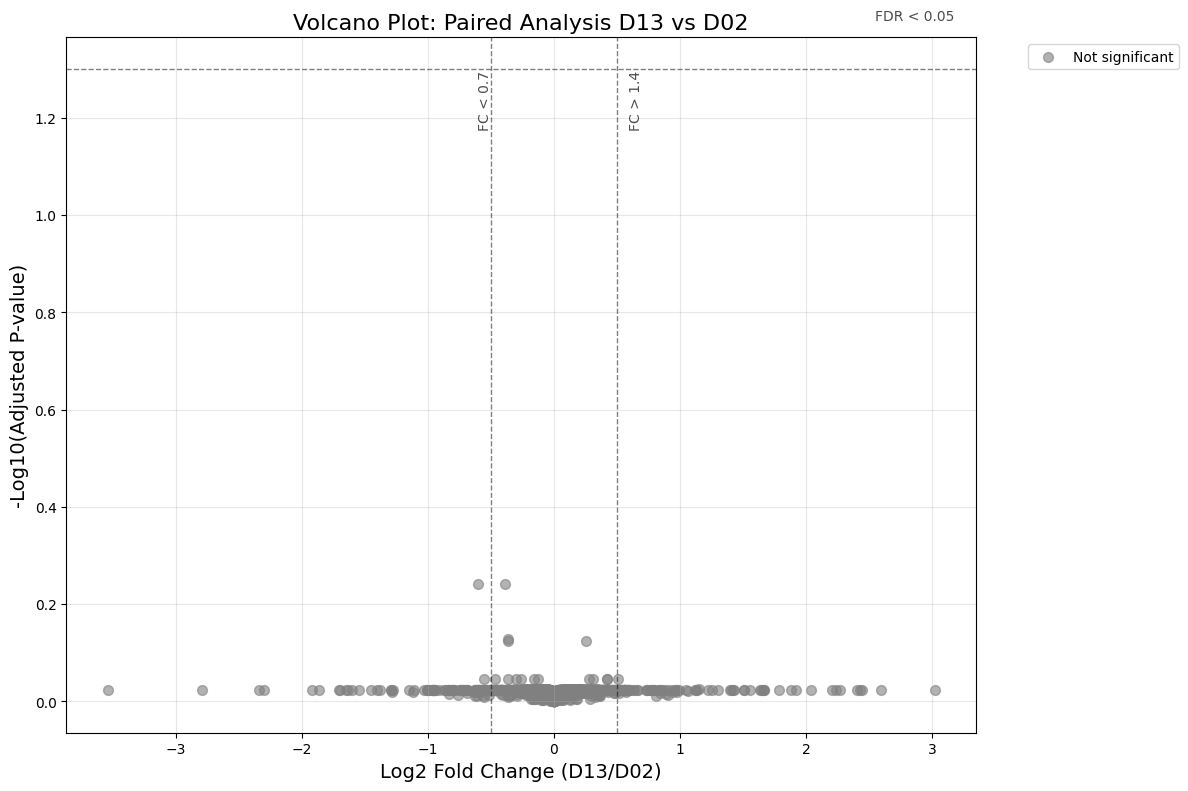


PAIRED DIFFERENTIAL ANALYSIS RESULTS (MEDIAN NORMALIZED DATA)
Analysis type: paired
Comparison: D13 vs D02
Data normalization: MEDIAN
Transform: (Log2 of Median Normalized)
Total proteins analyzed: 3378
Significant proteins (FDR < 0.05): 0
Increased in D13 (logFC > 0.5, FDR < 0.05): 0
Decreased in D13 (logFC < -0.5, FDR < 0.05): 0

TOP 20 INCREASING PROTEINS IN D13 vs D02:
Protein         Gene         Description                         logFC    FC       P.Value      adj.P.Val   
------------------------------------------------------------------------------------------------------------------------
sp|Q6XQN6|PNCB  NAPRT        Nicotinate phosphoribosyltransfera  0.256    1.19     1.10e-03     7.51e-01    
sp|Q9UL46|PSME  PSME2        Proteasome activator complex subun  0.422    1.34     3.07e-03     9.00e-01    
sp|Q6GTS8|P20D  PM20D1       N-fatty-acyl-amino acid synthase/h  0.418    1.34     3.27e-03     9.00e-01    
sp|Q8IZJ1|UNC5  UNC5B        Netrin receptor UNC5B               0

In [13]:
# Create Visualizations and Results Summary
if len(differential_df) > 0:
    
    # Set significance thresholds
    fc_threshold = 0.5  # log2 fold change threshold (equivalent to 1.4-fold change)
    p_threshold = 0.05  # adjusted p-value threshold
    
    # Create volcano plot
    plt.figure(figsize=(12, 8))
    
    # Calculate -log10(adj.P.Val) for volcano plot
    differential_df['neg_log10_adjP'] = -np.log10(differential_df['adj.P.Val'])
    
    # Create color categories
    colors = []
    for _, row in differential_df.iterrows():
        if row['adj.P.Val'] < p_threshold and abs(row['logFC']) > fc_threshold:
            if row['logFC'] > fc_threshold:
                colors.append('red')  # Increased in group2
            else:
                colors.append('blue')  # Decreased in group2
        elif row['adj.P.Val'] < p_threshold:
            colors.append('orange')  # Significant but small fold change
        else:
            colors.append('gray')  # Not significant
    
    differential_df['color'] = colors
    
    # Create scatter plot
    for color in ['gray', 'orange', 'blue', 'red']:
        subset = differential_df[differential_df['color'] == color]
        if len(subset) > 0:
            label_map = {
                'gray': 'Not significant',
                'orange': 'Significant (small FC)',
                'blue': f'Decreased in {group2}',
                'red': f'Increased in {group2}'
            }
            plt.scatter(subset['logFC'], subset['neg_log10_adjP'], 
                       c=color, alpha=0.6, s=50, label=label_map[color])
    
    # Add threshold lines
    plt.axvline(x=fc_threshold, color='black', linestyle='--', alpha=0.5, linewidth=1)
    plt.axvline(x=-fc_threshold, color='black', linestyle='--', alpha=0.5, linewidth=1)
    plt.axhline(y=-np.log10(p_threshold), color='black', linestyle='--', alpha=0.5, linewidth=1)
    
    # Add threshold labels
    plt.text(fc_threshold + 0.1, plt.ylim()[1] * 0.95, f'FC > {2**fc_threshold:.1f}', 
             rotation=90, va='top', fontsize=10, alpha=0.7)
    plt.text(-fc_threshold - 0.1, plt.ylim()[1] * 0.95, f'FC < {2**(-fc_threshold):.1f}', 
             rotation=90, va='top', fontsize=10, alpha=0.7)
    plt.text(plt.xlim()[1] * 0.95, -np.log10(p_threshold) + 0.1, f'FDR < {p_threshold}', 
             ha='right', fontsize=10, alpha=0.7)
    
    plt.xlabel(f'Log2 Fold Change ({group2}/{group1})', fontsize=14)
    plt.ylabel('-Log10(Adjusted P-value)', fontsize=14)
    plt.title(f'Volcano Plot: {analysis_type.capitalize()} Analysis {group2} vs {group1}', fontsize=16)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Annotate top significant proteins
    significant_proteins = differential_df[
        (differential_df['adj.P.Val'] < p_threshold) & 
        (abs(differential_df['logFC']) > fc_threshold)
    ].nsmallest(10, 'adj.P.Val')
    
    for _, row in significant_proteins.iterrows():
        protein_label = str(row['Protein'])[:15]
        plt.annotate(protein_label, 
                    (row['logFC'], row['neg_log10_adjP']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.8,
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*120)
    print(f"{analysis_type.upper()} DIFFERENTIAL ANALYSIS RESULTS ({normalization_method.upper()} NORMALIZED DATA)")
    print("="*120)
    print(f"Analysis type: {analysis_type}")
    print(f"Comparison: {group2} vs {group1}")
    print(f"Data normalization: {normalization_method.upper()}")
    print(f"Transform: {transform_label}")
    print(f"Total proteins analyzed: {len(differential_df)}")
    print(f"Significant proteins (FDR < {p_threshold}): {differential_df['Significant'].sum()}")
    print(f"Increased in {group2} (logFC > {fc_threshold}, FDR < {p_threshold}): {((differential_df['logFC'] > fc_threshold) & (differential_df['adj.P.Val'] < p_threshold)).sum()}")
    print(f"Decreased in {group2} (logFC < -{fc_threshold}, FDR < {p_threshold}): {((differential_df['logFC'] < -fc_threshold) & (differential_df['adj.P.Val'] < p_threshold)).sum()}")

    # Top increasing proteins
    top_up = differential_df[(differential_df['logFC'] > 0)].nsmallest(20, 'adj.P.Val')
    if len(top_up) > 0:
        print(f"\nTOP 20 INCREASING PROTEINS IN {group2} vs {group1}:")
        print("="*120)
        print(f"{'Protein':<15} {'Gene':<12} {'Description':<35} {'logFC':<8} {'FC':<8} {'P.Value':<12} {'adj.P.Val':<12}")
        print("-" * 120)
        for _, row in top_up.iterrows():
            protein_short = str(row['Protein'])[:14] if len(str(row['Protein'])) > 14 else str(row['Protein'])
            gene_short = str(row['Gene_Names_Display'])[:11] if len(str(row['Gene_Names_Display'])) > 11 else str(row['Gene_Names_Display'])
            desc_short = str(row['Protein_Names_Display'])[:34] if len(str(row['Protein_Names_Display'])) > 34 else str(row['Protein_Names_Display'])
            
            print(f"{protein_short:<15} {gene_short:<12} {desc_short:<35} {row['logFC']:<8.3f} {row['FC']:<8.2f} {row['P.Value']:<12.2e} {row['adj.P.Val']:<12.2e}")
    
    # Top decreasing proteins
    top_down = differential_df[(differential_df['logFC'] < 0)].nsmallest(20, 'adj.P.Val')
    if len(top_down) > 0:
        print(f"\nTOP 20 DECREASING PROTEINS IN {group2} vs {group1}:")
        print("="*120)
        print(f"{'Protein':<15} {'Gene':<12} {'Description':<35} {'logFC':<8} {'FC':<8} {'P.Value':<12} {'adj.P.Val':<12}")
        print("-" * 120)
        for _, row in top_down.iterrows():
            protein_short = str(row['Protein'])[:14] if len(str(row['Protein'])) > 14 else str(row['Protein'])
            gene_short = str(row['Gene_Names_Display'])[:11] if len(str(row['Gene_Names_Display'])) > 11 else str(row['Gene_Names_Display'])
            desc_short = str(row['Protein_Names_Display'])[:34] if len(str(row['Protein_Names_Display'])) > 34 else str(row['Protein_Names_Display'])
            
            print(f"{protein_short:<15} {gene_short:<12} {desc_short:<35} {row['logFC']:<8.3f} {row['FC']:<8.2f} {row['P.Value']:<12.2e} {row['adj.P.Val']:<12.2e}")
    
    # Save results
    filename = f"{analysis_type}_{normalization_method}_differential_results_{group2}_vs_{group1}.csv"
    
    # Determine output columns based on available data
    output_cols = ['Protein', 'logFC', 'AveExpr', 'SE', 't', 'P.Value', 'adj.P.Val', 'FC', 'CI.L', 'CI.R']
    
    # Add sample size columns
    if 'n_subjects' in differential_df.columns:
        output_cols.append('n_subjects')
    if 'n1' in differential_df.columns and 'n2' in differential_df.columns:
        output_cols.extend(['n1', 'n2'])
    
    # Add annotation columns if available
    annotation_cols = [col for col in differential_df.columns 
                      if col not in output_cols and col not in ['color', 'neg_log10_adjP', 'Significant', 'analysis_type', 'Gene_Names_Display', 'Protein_Names_Display']]
    output_cols.extend(annotation_cols)
    
    # Filter to available columns
    available_output_cols = [col for col in output_cols if col in differential_df.columns]
    
    output_df = differential_df[available_output_cols].copy()
    output_df.to_csv(filename, index=False)
    
    print(f"\n" + "="*120)
    print(f"Results saved to: {filename}")
    print(f"Analysis type: {analysis_type.capitalize()} differential analysis")
    print(f"Data normalization: {normalization_method.upper()}")
    print(f"Statistical test: {'Paired t-test' if analysis_type == 'paired' else 'Unpaired t-test'} with FDR correction")
    print("="*120)
    
else:
    print("No differential analysis results to visualize.")
    print("Please check the analysis configuration and re-run the previous cell.")

In [14]:
# Mann-Whitney U Test Differential Analysis
print("="*80)
print("MANN-WHITNEY U TEST DIFFERENTIAL ANALYSIS")
print("="*80)

# === MANN-WHITNEY ANALYSIS CONFIGURATION ===
# MODIFY THESE SETTINGS based on your experimental design

# 1. Analysis type: 'paired' (Wilcoxon signed-rank) or 'unpaired' (Mann-Whitney U)
mw_analysis_type = 'paired'  # Change to 'paired' for within-subject comparisons

# 2. Groups to compare (choose from available groups)
mw_group1 = 'D02'           # Reference group 
mw_group2 = 'D13'   # Test group

# 3. Normalization method to use for analysis
mw_normalization_method = 'median'  # 'median' or 'vsn'

# 4. Statistical thresholds
mw_effect_threshold = 0.2   # Effect size threshold (adjust based on data scale)
mw_p_threshold = 0.05       # adjusted p-value threshold

# 5. Subject identifier (for paired analysis)
mw_subject_column = 'Subject'  # Modify if your subject column has a different name

print("MANN-WHITNEY ANALYSIS CONFIGURATION")
print("="*80)
print(f"Analysis type: {mw_analysis_type}")
print(f"Comparison: {mw_group2} vs {mw_group1} (reference)")
print(f"Normalization: {mw_normalization_method}")
print(f"Effect size threshold: {mw_effect_threshold}")
print(f"Adjusted p-value threshold: {mw_p_threshold}")
if mw_analysis_type == 'paired':
    print(f"Subject identifier column: {mw_subject_column}")
print("="*80)

# Import required libraries for Mann-Whitney analysis
from scipy.stats import wilcoxon, mannwhitneyu

# Validate configuration
if mw_group1 in available_groups and mw_group2 in available_groups:
    print(f"✓ Groups validated: {mw_group2} vs {mw_group1}")
    
    # Get samples for each group
    mw_group1_samples = [s for s in cleaned_sample_names if sample_metadata[s]['Group'] == mw_group1]
    mw_group2_samples = [s for s in cleaned_sample_names if sample_metadata[s]['Group'] == mw_group2]
    
    print(f"\nSample counts:")
    print(f"  {mw_group1}: {len(mw_group1_samples)} samples")
    print(f"  {mw_group2}: {len(mw_group2_samples)} samples")
    
    # Select normalization data
    if mw_normalization_method == 'median':
        mw_analysis_data = median_normalized_data
        mw_transform_label = "(Median Normalized)"
        print(f"\n✓ Using median normalized data for Mann-Whitney analysis")
    elif mw_normalization_method == 'vsn':
        mw_analysis_data = vsn_normalized_data
        mw_transform_label = "(VSN Normalized)"
        print(f"\n✓ Using VSN normalized data for Mann-Whitney analysis")
    else:
        print(f"\nERROR: Invalid normalization method '{mw_normalization_method}'!")
        mw_analysis_data = None
        
    if mw_analysis_data is not None:
        # Perform Mann-Whitney analysis
        print(f"\nPerforming {mw_analysis_type} Mann-Whitney analysis...")
        
        mann_whitney_results = []
        
        for protein_idx in range(len(mw_analysis_data)):
            try:
                protein_id = processed_data.index[protein_idx]
                
                # Get expression values for this protein
                protein_expression = mw_analysis_data.iloc[protein_idx, :]
                
                if mw_analysis_type == 'paired':
                    # Paired analysis using Wilcoxon signed-rank test
                    # First identify paired samples (reuse logic from t-test analysis)
                    if 'paired_samples' in locals():
                        paired_values_1 = []
                        paired_values_2 = []
                        
                        for pair in paired_samples:
                            if (pair['group1_sample'] in protein_expression.index and 
                                pair['group2_sample'] in protein_expression.index):
                                
                                group1_expr = protein_expression[pair['group1_sample']]
                                group2_expr = protein_expression[pair['group2_sample']]
                                
                                if pd.notna(group1_expr) and pd.notna(group2_expr):
                                    paired_values_1.append(group1_expr)
                                    paired_values_2.append(group2_expr)
                        
                        if len(paired_values_1) >= 5:  # Need at least 5 pairs
                            # Calculate differences for effect size
                            differences = np.array(paired_values_2) - np.array(paired_values_1)
                            
                            if np.sum(differences != 0) >= 3:  # Need some non-zero differences
                                statistic, p_value = wilcoxon(paired_values_1, paired_values_2, alternative='two-sided')
                                
                                # Calculate effect size measures
                                median_group1 = np.median(paired_values_1)
                                median_group2 = np.median(paired_values_2)
                                median_diff = median_group2 - median_group1
                                
                                # Effect size calculation
                                pooled_std = np.std(paired_values_1 + paired_values_2)
                                effect_size = abs(median_diff) / pooled_std if pooled_std > 0 else 0
                                
                                mann_whitney_results.append({
                                    'Protein': protein_id,
                                    'n_pairs': len(paired_values_1),
                                    'median_group1': median_group1,
                                    'median_group2': median_group2,
                                    'median_diff': median_diff,
                                    'effect_size': effect_size,
                                    'statistic': statistic,
                                    'p_value': p_value,
                                    'analysis_type': 'paired'
                                })
                    else:
                        print("Warning: No paired samples identified for paired Mann-Whitney analysis")
                        continue
                        
                else:
                    # Unpaired analysis using Mann-Whitney U test
                    group1_values = protein_expression[mw_group1_samples].dropna()
                    group2_values = protein_expression[mw_group2_samples].dropna()
                    
                    if len(group1_values) >= 3 and len(group2_values) >= 3:
                        statistic, p_value = mannwhitneyu(group2_values, group1_values, alternative='two-sided')
                        
                        # Calculate effect size measures
                        median_group1 = np.median(group1_values)
                        median_group2 = np.median(group2_values)
                        median_diff = median_group2 - median_group1
                        
                        # Effect size calculation (Cohen's d equivalent for medians)
                        pooled_std = np.sqrt((np.var(group1_values) + np.var(group2_values)) / 2)
                        effect_size = abs(median_diff) / pooled_std if pooled_std > 0 else 0
                        
                        mann_whitney_results.append({
                            'Protein': protein_id,
                            'n1': len(group1_values),
                            'n2': len(group2_values),
                            'median_group1': median_group1,
                            'median_group2': median_group2,
                            'median_diff': median_diff,
                            'effect_size': effect_size,
                            'statistic': statistic,
                            'p_value': p_value,
                            'analysis_type': 'unpaired'
                        })
                        
            except Exception as e:
                # Skip proteins that cause errors
                continue
        
        print(f"Mann-Whitney analysis completed on {len(mann_whitney_results)} proteins")
        
        if len(mann_whitney_results) > 0:
            # Convert to DataFrame
            mw_results_df = pd.DataFrame(mann_whitney_results)
            
            # Add gene names and annotations
            if 'processed_data' in globals():
                mw_results_df['Gene'] = mw_results_df['Protein'].apply(
                    lambda x: processed_data.loc[x, 'Gene'] if x in processed_data.index else str(x)
                )
                
                mw_results_df['Protein_ID'] = mw_results_df['Protein'].apply(
                    lambda x: processed_data.loc[x, 'Protein'] if x in processed_data.index and 'Protein' in processed_data.columns else str(x)
                )
                
                mw_results_df['Description'] = mw_results_df['Protein'].apply(
                    lambda x: processed_data.loc[x, 'Description'] if x in processed_data.index and 'Description' in processed_data.columns else ''
                )
            
            # Apply multiple testing correction
            rejected, p_adj, _, _ = multipletests(mw_results_df['p_value'], method='fdr_bh')
            mw_results_df['adj_p_value'] = p_adj
            mw_results_df['significant'] = rejected
            
            # Sort by p-value
            mw_results_df = mw_results_df.sort_values('p_value')
            
            print(f"\nMANN-WHITNEY ANALYSIS RESULTS:")
            print(f"Total proteins tested: {len(mw_results_df)}")
            print(f"Significant proteins (FDR < {mw_p_threshold}): {mw_results_df['significant'].sum()}")
            
            higher_count = sum((mw_results_df['median_diff'] > mw_effect_threshold) & (mw_results_df['significant']))
            lower_count = sum((mw_results_df['median_diff'] < -mw_effect_threshold) & (mw_results_df['significant']))
            
            print(f"Higher in {mw_group2} (diff > {mw_effect_threshold}, FDR < {mw_p_threshold}): {higher_count}")
            print(f"Lower in {mw_group2} (diff < -{mw_effect_threshold}, FDR < {mw_p_threshold}): {lower_count}")
            
        else:
            print("No valid results from Mann-Whitney analysis")
            mw_results_df = None
            
else:
    print(f"ERROR: Invalid group selection for Mann-Whitney analysis")
    print(f"Available groups: {available_groups}")
    mw_results_df = None

MANN-WHITNEY U TEST DIFFERENTIAL ANALYSIS
MANN-WHITNEY ANALYSIS CONFIGURATION
Analysis type: paired
Comparison: D13 vs D02 (reference)
Normalization: median
Effect size threshold: 0.2
Adjusted p-value threshold: 0.05
Subject identifier column: Subject
✓ Groups validated: D13 vs D02

Sample counts:
  D02: 18 samples
  D13: 18 samples

✓ Using median normalized data for Mann-Whitney analysis

Performing paired Mann-Whitney analysis...
Mann-Whitney analysis completed on 3378 proteins

MANN-WHITNEY ANALYSIS RESULTS:
Total proteins tested: 3378
Significant proteins (FDR < 0.05): 0
Higher in D13 (diff > 0.2, FDR < 0.05): 0
Lower in D13 (diff < -0.2, FDR < 0.05): 0
Mann-Whitney analysis completed on 3378 proteins

MANN-WHITNEY ANALYSIS RESULTS:
Total proteins tested: 3378
Significant proteins (FDR < 0.05): 0
Higher in D13 (diff > 0.2, FDR < 0.05): 0
Lower in D13 (diff < -0.2, FDR < 0.05): 0



MANN-WHITNEY U TEST RESULTS (MEDIAN NORMALIZED DATA)


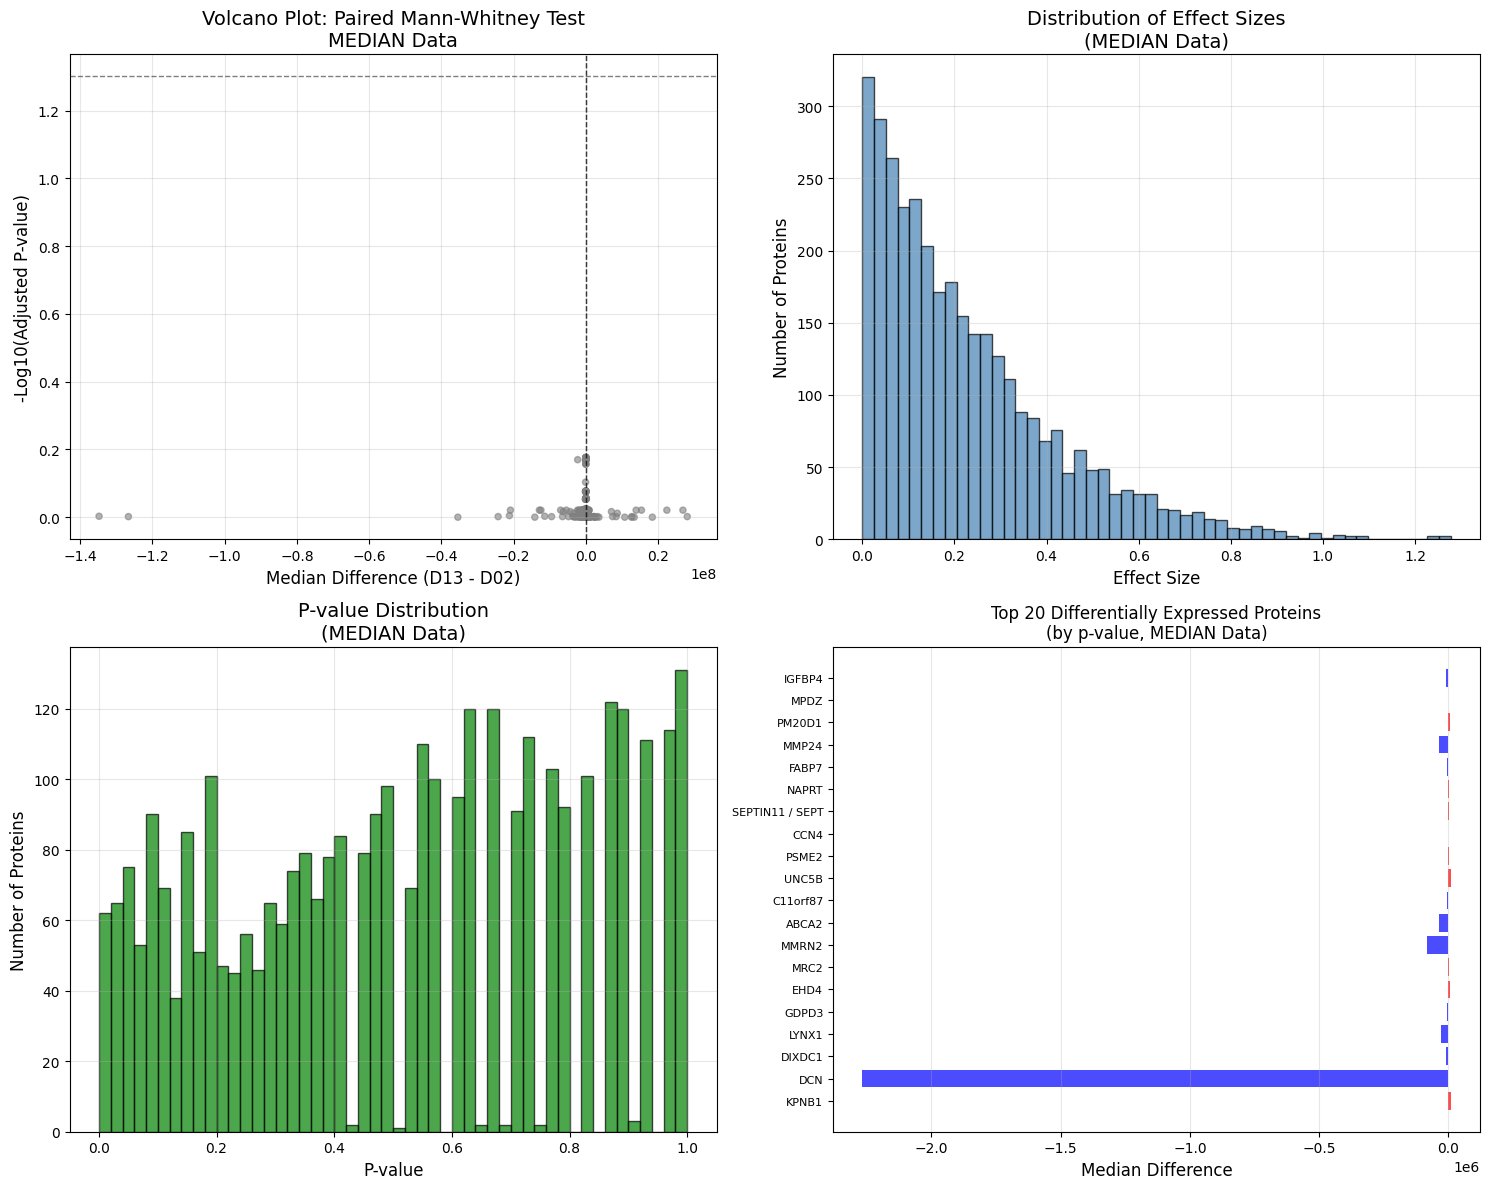


Top 20 proteins higher in D13 vs D02:
Protein              Gene         Description                              Med_Diff   P.Value      adj.P.Val   
------------------------------------------------------------------------------------------------------------------------
sp|Q6GTS8|P20D1_HUM  PM20D1       N-fatty-acyl-amino acid synthase/hydrol  5862.263   8.39e-04     6.67e-01    
sp|Q6XQN6|PNCB_HUMA  NAPRT        Nicotinate phosphoribosyltransferase     2331.475   1.58e-03     6.67e-01    
sp|Q9NVA2|SEP11_HUM  SEPTIN11 /   Septin-11                                768.795    1.58e-03     6.67e-01    
sp|Q9UL46|PSME2_HUM  PSME2        Proteasome activator complex subunit 2   2888.633   2.33e-03     6.77e-01    
sp|Q8IZJ1|UNC5B_HUM  UNC5B        Netrin receptor UNC5B                    8596.428   2.33e-03     6.77e-01    
sp|Q9UBG0|MRC2_HUMA  MRC2         C-type mannose receptor 2                2162.661   4.01e-03     6.77e-01    
sp|Q9H223|EHD4_HUMA  EHD4         EH domain-containing p

In [15]:
# Mann-Whitney Results Visualization and Display
if 'mw_results_df' in locals() and mw_results_df is not None and len(mw_results_df) > 0:
    
    print("\n" + "="*120)
    print(f"MANN-WHITNEY U TEST RESULTS ({mw_normalization_method.upper()} NORMALIZED DATA)")
    print("="*120)
    
    # Create comprehensive visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Volcano plot
    plt.subplot(2, 2, 1)
    neg_log10_p = -np.log10(mw_results_df['adj_p_value'].fillna(1.0))
    median_diff = mw_results_df['median_diff'].fillna(0)
    
    # Color points based on significance and effect size
    colors = []
    for _, row in mw_results_df.iterrows():
        if row['significant'] and abs(row['median_diff']) > mw_effect_threshold:
            if row['median_diff'] > mw_effect_threshold:
                colors.append('red')  # Higher in group2
            else:
                colors.append('blue')  # Lower in group2
        elif row['significant']:
            colors.append('orange')  # Significant but small effect
        else:
            colors.append('gray')  # Not significant
    
    plt.scatter(median_diff, neg_log10_p, c=colors, alpha=0.6, s=20)
    plt.axhline(y=-np.log10(mw_p_threshold), color='black', linestyle='--', alpha=0.5, linewidth=1)
    plt.axvline(x=mw_effect_threshold, color='black', linestyle='--', alpha=0.5, linewidth=1)
    plt.axvline(x=-mw_effect_threshold, color='black', linestyle='--', alpha=0.5, linewidth=1)
    
    plt.xlabel(f'Median Difference ({mw_group2} - {mw_group1})', fontsize=12)
    plt.ylabel('-Log10(Adjusted P-value)', fontsize=12)
    plt.title(f'Volcano Plot: {mw_analysis_type.title()} Mann-Whitney Test\n{mw_normalization_method.upper()} Data', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # 2. Effect size distribution
    plt.subplot(2, 2, 2)
    plt.hist(mw_results_df['effect_size'].fillna(0), bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    plt.xlabel('Effect Size', fontsize=12)
    plt.ylabel('Number of Proteins', fontsize=12)
    plt.title(f'Distribution of Effect Sizes\n({mw_normalization_method.upper()} Data)', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # 3. P-value distribution
    plt.subplot(2, 2, 3)
    plt.hist(mw_results_df['p_value'].fillna(1.0), bins=50, alpha=0.7, color='green', edgecolor='black')
    plt.xlabel('P-value', fontsize=12)
    plt.ylabel('Number of Proteins', fontsize=12)
    plt.title(f'P-value Distribution\n({mw_normalization_method.upper()} Data)', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # 4. Top proteins by effect size
    plt.subplot(2, 2, 4)
    top_proteins_mw = mw_results_df.nsmallest(20, 'p_value')
    y_pos = np.arange(len(top_proteins_mw))
    colors_bar = ['red' if diff > 0 else 'blue' for diff in top_proteins_mw['median_diff']]
    
    protein_labels = []
    for _, row in top_proteins_mw.iterrows():
        if 'Gene' in row and pd.notna(row['Gene']) and str(row['Gene']).strip():
            protein_labels.append(str(row['Gene'])[:15])
        else:
            protein_labels.append(str(row['Protein'])[:15])
    
    # Reverse the order so best p-value (lowest) appears at the top
    plt.barh(y_pos, top_proteins_mw['median_diff'].fillna(0), color=colors_bar, alpha=0.7)
    plt.yticks(y_pos, protein_labels, fontsize=8)
    plt.xlabel('Median Difference', fontsize=12)
    plt.title(f'Top 20 Differentially Expressed Proteins\n(by p-value, {mw_normalization_method.upper()} Data)', fontsize=12)
    plt.grid(True, alpha=0.3, axis='x')
    plt.gca().invert_yaxis()  # Invert y-axis so best p-value is at the top
    
    plt.tight_layout()
    plt.show()
    
    # Display results tables
    print(f"\nTop 20 proteins higher in {mw_group2} vs {mw_group1}:")
    print("="*120)
    print(f"{'Protein':<20} {'Gene':<12} {'Description':<40} {'Med_Diff':<10} {'P.Value':<12} {'adj.P.Val':<12}")
    print("-" * 120)
    
    top_higher_mw = mw_results_df[(mw_results_df['median_diff'] > 0)].nsmallest(20, 'adj_p_value')
    for _, row in top_higher_mw.iterrows():
        protein_short = str(row['Protein_ID'])[:19] if 'Protein_ID' in row else str(row['Protein'])[:19]
        gene_short = str(row['Gene'])[:11] if 'Gene' in row and pd.notna(row['Gene']) else 'Unknown'
        desc_short = str(row['Description'])[:39] if 'Description' in row and pd.notna(row['Description']) else 'Unknown'
        
        print(f"{protein_short:<20} {gene_short:<12} {desc_short:<40} {row['median_diff']:<10.3f} {row['p_value']:<12.2e} {row['adj_p_value']:<12.2e}")
    
    print(f"\nTop 20 proteins lower in {mw_group2} vs {mw_group1}:")
    print("="*120)
    print(f"{'Protein':<20} {'Gene':<12} {'Description':<40} {'Med_Diff':<10} {'P.Value':<12} {'adj.P.Val':<12}")
    print("-" * 120)
    
    top_lower_mw = mw_results_df[(mw_results_df['median_diff'] < 0)].nsmallest(20, 'adj_p_value')
    for _, row in top_lower_mw.iterrows():
        protein_short = str(row['Protein_ID'])[:19] if 'Protein_ID' in row else str(row['Protein'])[:19]
        gene_short = str(row['Gene'])[:11] if 'Gene' in row and pd.notna(row['Gene']) else 'Unknown'
        desc_short = str(row['Description'])[:39] if 'Description' in row and pd.notna(row['Description']) else 'Unknown'
        
        print(f"{protein_short:<20} {gene_short:<12} {desc_short:<40} {row['median_diff']:<10.3f} {row['p_value']:<12.2e} {row['adj_p_value']:<12.2e}")
    
    # Save results to CSV
    mw_output_filename = f"{mw_analysis_type}_mann_whitney_analysis_{mw_group2}_vs_{mw_group1}_{mw_normalization_method}_normalized.csv"
    mw_output_filename = mw_output_filename.replace(' ', '_')
    
    # Prepare output columns
    mw_output_cols = ['Protein_ID', 'Gene', 'Description', 'median_diff', 'effect_size', 'statistic', 'p_value', 'adj_p_value', 'significant']
    
    # Add sample size columns based on analysis type
    if mw_analysis_type == 'paired':
        mw_output_cols.insert(-5, 'n_pairs')
    else:
        mw_output_cols.insert(-5, 'n1')
        mw_output_cols.insert(-4, 'n2')
    
    # Filter columns that actually exist
    existing_cols = [col for col in mw_output_cols if col in mw_results_df.columns]
    
    try:
        mw_results_df[existing_cols].to_csv(mw_output_filename, index=False)
        print(f"\n✓ Successfully saved Mann-Whitney results: {mw_output_filename}")
    except Exception as e:
        print(f"✗ Error saving {mw_output_filename}: {e}")
    
    # Feature selection - top proteins for downstream analysis
    TOP_N_FEATURES = 500
    print(f"\n" + "="*80)
    print(f"SELECTING TOP {TOP_N_FEATURES} PROTEINS FOR FEATURE SELECTION")
    print("="*80)
    
    top_proteins_for_selection = mw_results_df.head(TOP_N_FEATURES)['Protein'].tolist()
    
    # Save selected proteins
    selected_proteins_df = pd.DataFrame({
        'Protein': top_proteins_for_selection,
        'Rank': range(1, len(top_proteins_for_selection) + 1),
        'P_Value': mw_results_df.head(TOP_N_FEATURES)['p_value'].values,
        'Adj_P_Value': mw_results_df.head(TOP_N_FEATURES)['adj_p_value'].values,
        'Median_Diff': mw_results_df.head(TOP_N_FEATURES)['median_diff'].values
    })
    
    selection_filename = f"top_{TOP_N_FEATURES}_proteins_mann_whitney_{mw_normalization_method}.csv"
    selected_proteins_df.to_csv(selection_filename, index=False)
    
    print(f"Selected {len(top_proteins_for_selection)} proteins for feature selection")
    print(f"These represent the most differentially expressed proteins using Mann-Whitney test")
    print(f"Results saved to: {selection_filename}")
    
    print(f"\n" + "="*120)
    print(f"MANN-WHITNEY ANALYSIS SUMMARY:")
    print(f"Analysis type: {mw_analysis_type.upper()}")
    print(f"Statistical test: {'Wilcoxon signed-rank' if mw_analysis_type == 'paired' else 'Mann-Whitney U'}")
    print(f"Comparison: {mw_group2} vs {mw_group1} (reference)")
    print(f"Normalization: {mw_normalization_method.upper()} {mw_transform_label}")
    print(f"Effect size threshold: ±{mw_effect_threshold}")
    print(f"Adjusted p-value threshold: {mw_p_threshold}")
    print(f"Total proteins tested: {len(mw_results_df)}")
    print(f"Significant proteins: {mw_results_df['significant'].sum()}")
    print(f"Higher in {mw_group2}: {higher_count}")
    print(f"Lower in {mw_group2}: {lower_count}")
    print(f"Results saved to: {mw_output_filename}")
    print(f"Top features saved to: {selection_filename}")
    print("="*120)
    
else:
    print("No Mann-Whitney results available to display.")

In [16]:
# Binary Classification Analysis with SVM
print("="*80)
print("BINARY CLASSIFICATION ANALYSIS")
print("="*80)

# === CLASSIFICATION ANALYSIS CONFIGURATION ===
# MODIFY THESE SETTINGS based on your experimental design

# 1. Analysis type: 'paired' or 'unpaired'
clf_analysis_type = 'paired'  # Change to 'paired' for within-subject comparisons

# 2. Groups to compare (choose from available groups)
clf_group1 = 'D02'           # Reference group (class 0)
clf_group2 = 'D13'   # Test group (class 1)

# 3. Normalization method to use for analysis
clf_normalization_method = 'median'  # 'median' or 'vsn'

# 4. Feature selection parameters
clf_top_features = 80       # Number of top features to use from differential analysis
clf_final_features = 20     # Final number of features after selection

# 5. Cross-validation parameters
clf_cv_folds = 5           # Number of CV folds (will be adjusted based on sample size)
clf_random_state = 42      # Random state for reproducibility

# 6. Subject identifier (for paired analysis)
clf_subject_column = 'Subject'  # Modify if your subject column has a different name

print("CLASSIFICATION ANALYSIS CONFIGURATION")
print("="*80)
print(f"Analysis type: {clf_analysis_type}")
print(f"Comparison: {clf_group2} (class 1) vs {clf_group1} (class 0)")
print(f"Normalization: {clf_normalization_method}")
print(f"Top features for selection: {clf_top_features}")
print(f"Final features after selection: {clf_final_features}")
print(f"CV folds: {clf_cv_folds}")
print(f"Random state: {clf_random_state}")
if clf_analysis_type == 'paired':
    print(f"Subject identifier column: {clf_subject_column}")
print("="*80)

# Import required libraries for classification
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
import warnings

# Validate configuration
if clf_group1 in available_groups and clf_group2 in available_groups:
    print(f"✓ Groups validated: {clf_group2} vs {clf_group1}")
    
    # Get samples for each group
    clf_group1_samples = [s for s in cleaned_sample_names if sample_metadata[s]['Group'] == clf_group1]
    clf_group2_samples = [s for s in cleaned_sample_names if sample_metadata[s]['Group'] == clf_group2]
    
    print(f"\nSample counts:")
    print(f"  {clf_group1}: {len(clf_group1_samples)} samples")
    print(f"  {clf_group2}: {len(clf_group2_samples)} samples")
    
    # Select normalization data
    if clf_normalization_method == 'median':
        clf_analysis_data = median_normalized_data
        clf_transform_label = "(Median Normalized)"
        print(f"\n✓ Using median normalized data for classification")
    elif clf_normalization_method == 'vsn':
        clf_analysis_data = vsn_normalized_data
        clf_transform_label = "(VSN Normalized)"
        print(f"\n✓ Using VSN normalized data for classification")
    else:
        print(f"\nERROR: Invalid normalization method '{clf_normalization_method}'!")
        clf_analysis_data = None
        
    if clf_analysis_data is not None:
        # Feature selection - use top proteins from differential analysis
        print(f"\nSelecting top {clf_top_features} features for classification...")
        
        # Get feature importance from differential analysis results
        if 'results_df' in locals() and results_df is not None and len(results_df) > 0:
            # Sort by statistical significance and select top features
            top_proteins_by_significance = results_df.nsmallest(clf_top_features, 'P.Value')['Protein'].tolist()
            
            # Map protein names to indices in the data
            protein_to_idx = {protein: idx for idx, protein in enumerate(processed_data.index)}
            selected_protein_indices = [protein_to_idx[protein] for protein in top_proteins_by_significance if protein in protein_to_idx]
            
            print(f"Selected {len(selected_protein_indices)} proteins from differential analysis")
            
        elif 'mw_results_df' in locals() and mw_results_df is not None and len(mw_results_df) > 0:
            # Use Mann-Whitney results if available
            top_proteins_by_significance = mw_results_df.nsmallest(clf_top_features, 'p_value')['Protein'].tolist()
            
            # Map protein names to indices in the data
            protein_to_idx = {protein: idx for idx, protein in enumerate(processed_data.index)}
            selected_protein_indices = [protein_to_idx[protein] for protein in top_proteins_by_significance if protein in protein_to_idx]
            
            print(f"Selected {len(selected_protein_indices)} proteins from Mann-Whitney analysis")
            
        else:
            # Fallback: select top features by variance
            print("No differential analysis results found, using variance-based selection")
            feature_variances = clf_analysis_data.var(axis=1)
            top_variance_indices = feature_variances.nlargest(clf_top_features).index
            selected_protein_indices = [processed_data.index.get_loc(idx) for idx in top_variance_indices]
            
        print(f"Final selected features: {len(selected_protein_indices)}")
        
        if len(selected_protein_indices) == 0:
            print("ERROR: No features selected for classification")
            clf_analysis_data = None
        else:
            # Extract selected protein data
            selected_protein_data = clf_analysis_data.iloc[selected_protein_indices, :]
            
            # Create training data
            clf_features = []
            clf_labels = []
            clf_subject_ids = []
            
            print("Creating training data...")
            
            if clf_analysis_type == 'paired':
                # Paired analysis using subject pairing
                if 'paired_samples' in locals() and len(paired_samples) > 0:
                    print(f"Found {len(paired_samples)} paired subjects for classification")
                    
                    for pair in paired_samples:
                        subject = pair['subject']
                        group1_sample = pair['group1_sample']
                        group2_sample = pair['group2_sample']
                        
                        # Extract protein intensities for this subject pair
                        group1_intensities = selected_protein_data[group1_sample].values
                        group2_intensities = selected_protein_data[group2_sample].values
                        
                        # Apply log2 transform if using median normalized data
                        if clf_normalization_method == 'median':
                            pseudocount = selected_protein_data[selected_protein_data > 0].min().min() / 10
                            group1_log2 = np.log2(group1_intensities + pseudocount)
                            group2_log2 = np.log2(group2_intensities + pseudocount)
                        else:
                            # VSN data is already transformed
                            group1_log2 = group1_intensities
                            group2_log2 = group2_intensities
                        
                        # Create two samples per subject pair
                        clf_features.append(group1_log2)
                        clf_labels.append(0)  # Group1 class
                        clf_subject_ids.append(f"{subject}_{clf_group1}")
                        
                        clf_features.append(group2_log2)
                        clf_labels.append(1)  # Group2 class
                        clf_subject_ids.append(f"{subject}_{clf_group2}")
                        
                else:
                    print("ERROR: No paired samples found for paired classification")
                    clf_analysis_data = None
                    
            else:
                # Unpaired analysis
                all_samples = clf_group1_samples + clf_group2_samples
                
                for sample in all_samples:
                    if sample in clf_group1_samples:
                        group_label = 0
                        sample_id = f"{sample}_{clf_group1}"
                    else:
                        group_label = 1
                        sample_id = f"{sample}_{clf_group2}"
                    
                    # Extract protein intensities
                    sample_intensities = selected_protein_data[sample].values
                    
                    # Apply log2 transform if using median normalized data
                    if clf_normalization_method == 'median':
                        pseudocount = selected_protein_data[selected_protein_data > 0].min().min() / 10
                        sample_log2 = np.log2(sample_intensities + pseudocount)
                    else:
                        # VSN data is already transformed
                        sample_log2 = sample_intensities
                    
                    clf_features.append(sample_log2)
                    clf_labels.append(group_label)
                    clf_subject_ids.append(sample_id)
            
            if clf_analysis_data is not None:
                # Convert to arrays
                X_clf = np.array(clf_features)
                y_clf = np.array(clf_labels)
                
                print(f"Training data shape: {X_clf.shape}")
                print(f"Number of samples: {X_clf.shape[0]}")
                print(f"Number of features: {X_clf.shape[1]}")
                print(f"Class distribution - {clf_group1}: {np.sum(y_clf == 0)}, {clf_group2}: {np.sum(y_clf == 1)}")
                
                # PREPROCESSING FOR CLASSIFICATION
                print("\nApplying preprocessing for classification...")
                
                # Fill NaN values with median
                X_clf_processed = pd.DataFrame(X_clf).fillna(pd.DataFrame(X_clf).median()).values
                
                # Variance filtering - remove bottom 30% of variance
                feature_variance = np.var(X_clf_processed, axis=0)
                variance_threshold = np.percentile(feature_variance, 30)
                valid_features = feature_variance > variance_threshold
                X_clf_processed = X_clf_processed[:, valid_features]
                
                print(f"Features after variance filtering (30th percentile): {X_clf_processed.shape[1]}")
                
                # Stability check: remove features with extreme outliers
                feature_stability_scores = []
                for i in range(X_clf_processed.shape[1]):
                    feature_data = X_clf_processed[:, i]
                    q25, q75 = np.percentile(feature_data, [25, 75])
                    iqr = q75 - q25
                    outlier_threshold = 3 * iqr
                    outliers = np.sum((feature_data < q25 - outlier_threshold) | (feature_data > q75 + outlier_threshold))
                    stability_score = 1.0 - (outliers / len(feature_data))
                    feature_stability_scores.append(stability_score)
                
                # Keep features with stability score > 0.70
                stable_features = np.array(feature_stability_scores) > 0.70
                X_clf_processed = X_clf_processed[:, stable_features]
                
                print(f"Features after stability filtering (>70% non-outliers): {X_clf_processed.shape[1]}")
                
                if X_clf_processed.shape[1] == 0:
                    print("ERROR: No features survived preprocessing")
                else:
                    classification_successful = True
                    
else:
    print(f"ERROR: Invalid group selection for classification")
    print(f"Available groups: {available_groups}")
    classification_successful = False

BINARY CLASSIFICATION ANALYSIS
CLASSIFICATION ANALYSIS CONFIGURATION
Analysis type: paired
Comparison: D13 (class 1) vs D02 (class 0)
Normalization: median
Top features for selection: 80
Final features after selection: 20
CV folds: 5
Random state: 42
Subject identifier column: Subject
✓ Groups validated: D13 vs D02

Sample counts:
  D02: 18 samples
  D13: 18 samples

✓ Using median normalized data for classification

Selecting top 80 features for classification...
Selected 80 proteins from Mann-Whitney analysis
Final selected features: 80
Creating training data...
Found 18 paired subjects for classification
Training data shape: (36, 80)
Number of samples: 36
Number of features: 80
Class distribution - D02: 18, D13: 18

Applying preprocessing for classification...
Features after variance filtering (30th percentile): 56
Features after stability filtering (>70% non-outliers): 56
✓ Groups validated: D13 vs D02

Sample counts:
  D02: 18 samples
  D13: 18 samples

✓ Using median normalized d


Testing SVM hyperparameters...
  C =   0.01, class_weight =      None: CV AUC = 0.907 ± 0.069
  C =   0.01, class_weight =  balanced: CV AUC = 0.907 ± 0.069
  C =   0.10, class_weight =      None: CV AUC = 0.889 ± 0.039
  C =   0.10, class_weight =  balanced: CV AUC = 0.889 ± 0.039
  C =   1.00, class_weight =      None: CV AUC = 0.870 ± 0.013
  C =   1.00, class_weight =  balanced: CV AUC = 0.870 ± 0.013
  C =  10.00, class_weight =      None: CV AUC = 0.870 ± 0.013
  C =  10.00, class_weight =  balanced: CV AUC = 0.870 ± 0.013
  C = 100.00, class_weight =      None: CV AUC = 0.870 ± 0.013
  C = 100.00, class_weight =  balanced: CV AUC = 0.870 ± 0.013

Stability-based selection for SVM:
  Best AUC: 0.907
  Similar performers (within 0.010):
    C =   0.01, class_weight =      None: AUC = 0.907 ± 0.069 ← SELECTED (most stable)
    C =   0.01, class_weight =  balanced: AUC = 0.907 ± 0.069

Selected SVM parameters: C = 0.01, class_weight = None
Expected CV AUC = 0.907 ± 0.069

Performin

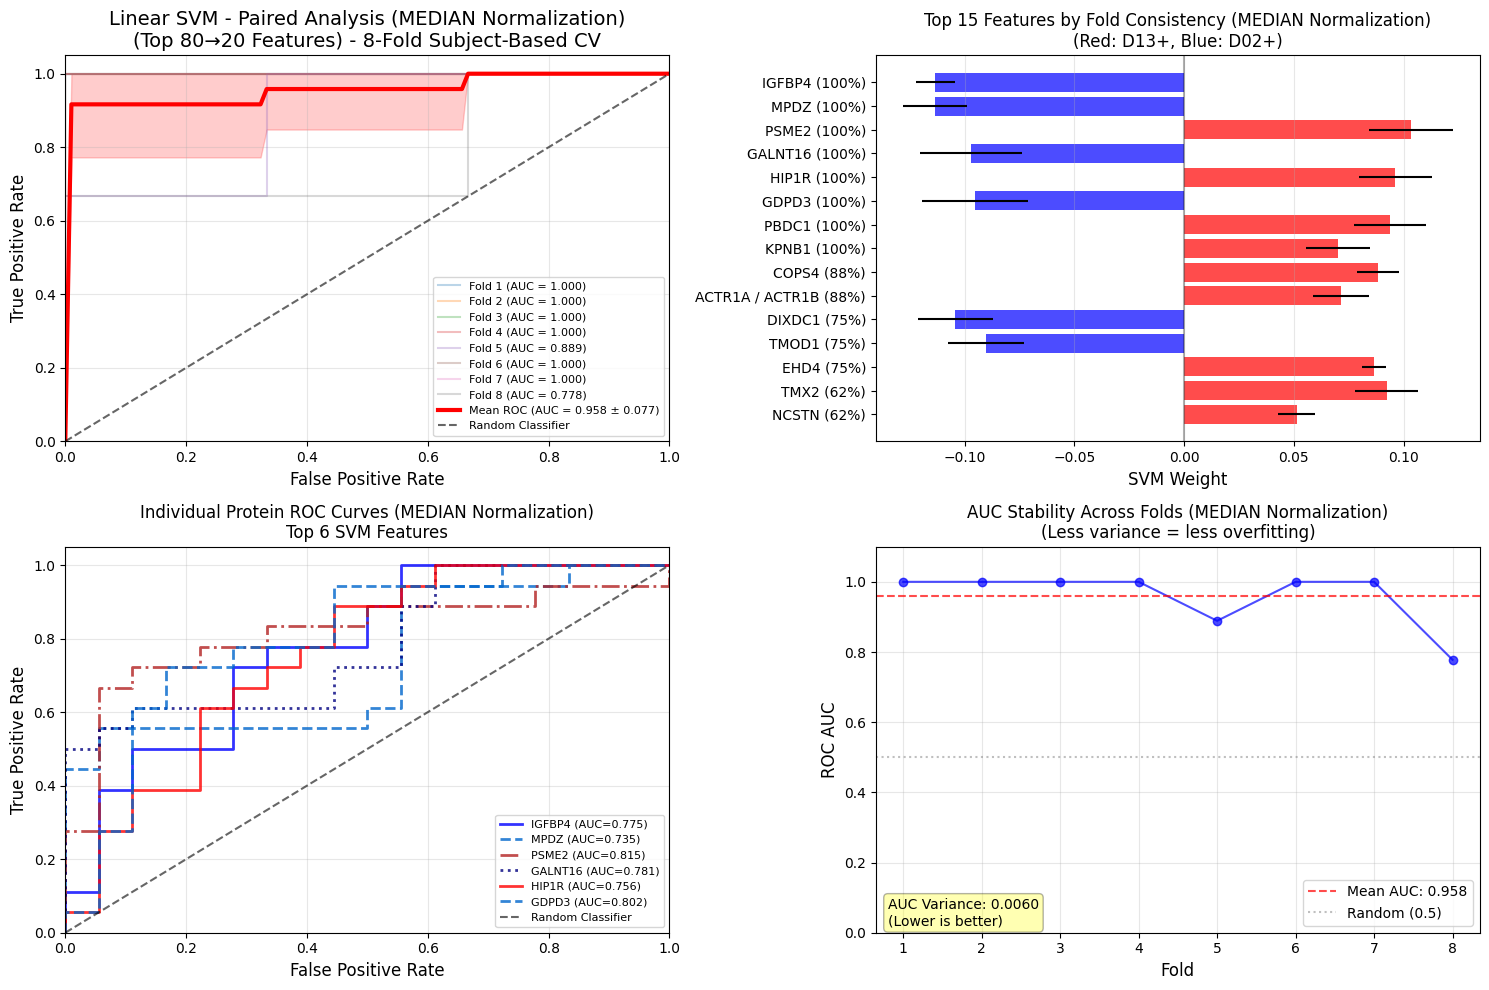


SVM CLASSIFICATION SUMMARY:
Analysis type: PAIRED
Comparison: D13 (class 1) vs D02 (class 0)
Normalization: MEDIAN (Median Normalized)
Cross-validation method: 8-Fold Enhanced High-Resolution Subject-Based CV
Number of folds completed: 8
Selected features: 80 → 20
Best SVM parameters: C = 0.01, class_weight = None
Mean Accuracy: 0.891 ± 0.123
Mean ROC AUC: 0.958 ± 0.077
AUC Variance: 0.0060 (lower indicates less overfitting)
Individual fold AUCs: ['1.000', '1.000', '1.000', '1.000', '0.889', '1.000', '1.000', '0.778']
GOOD: Low AUC variance suggests robust model

OVERFITTING PREVENTION MEASURES:
✓ Feature selection (top 20 from 80)
✓ Variance filtering (30th percentile)
✓ Stability filtering (outlier detection)
✓ Subject-aware cross-validation with 8 folds
✓ Hyperparameter tuning with nested CV
✓ Regularization (C = 0.01)
✓ Class weight balancing (None)
✓ Fold-percentage based feature selection
✓ Weight stability filtering (CV < 3.0)

FEATURE OUTPUT:
✓ Features saved to: paired_svm_fe

In [20]:
# SVM Training and Cross-Validation
if 'classification_successful' in locals() and classification_successful:
    
    # SVM HYPERPARAMETER TUNING
    print("\nTesting SVM hyperparameters...")
    
    # SVM hyperparameters to test
    svm_param_grid = {
        'C': [0.01, 0.1, 1.0, 10.0, 100.0],
        'class_weight': [None, 'balanced']
    }
    
    best_svm_params = None
    best_svm_score = 0
    best_svm_std = float('inf')
    
    # Store results for stability-based selection
    svm_results = []
    
    # Use nested cross-validation to select best parameters
    for C in svm_param_grid['C']:
        for class_weight in svm_param_grid['class_weight']:
            # Create pipeline with feature selection and SVM
            svm_pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(f_classif, k=min(clf_final_features, X_clf_processed.shape[1]))),
                ('classifier', SVC(
                    kernel='linear', 
                    C=C, 
                    class_weight=class_weight,
                    probability=True,  # Enable probability estimates for ROC
                    random_state=clf_random_state
                ))
            ])
            
            # Nested CV: inner loop for hyperparameter selection
            cv_scores = cross_val_score(svm_pipeline, X_clf_processed, y_clf, cv=3, scoring='roc_auc')
            mean_cv_score = np.mean(cv_scores)
            std_cv_score = np.std(cv_scores)
            
            svm_results.append({
                'C': C,
                'class_weight': class_weight,
                'mean_auc': mean_cv_score,
                'std_auc': std_cv_score,
                'cv_scores': cv_scores
            })
            
            print(f"  C = {C:6.2f}, class_weight = {str(class_weight):>9s}: CV AUC = {mean_cv_score:.3f} ± {std_cv_score:.3f}")
    
    # Select best parameters using stability-aware criteria
    svm_results.sort(key=lambda x: (-x['mean_auc'], x['std_auc']))
    
    # Find the best performance
    best_mean_auc = svm_results[0]['mean_auc']
    
    # Define similarity threshold (within 1% of best performance)
    similarity_threshold = 0.01
    
    # Filter candidates within similarity threshold
    similar_performers = [r for r in svm_results 
                         if abs(r['mean_auc'] - best_mean_auc) <= similarity_threshold]
    
    # Among similar performers, choose the one with lowest variance
    if len(similar_performers) > 1:
        most_stable = min(similar_performers, key=lambda x: x['std_auc'])
        best_svm_params = {'C': most_stable['C'], 'class_weight': most_stable['class_weight']}
        best_svm_score = most_stable['mean_auc']
        best_svm_std = most_stable['std_auc']
        
        print(f"\nStability-based selection for SVM:")
        print(f"  Best AUC: {best_mean_auc:.3f}")
        print(f"  Similar performers (within {similarity_threshold:.3f}):")
        for r in similar_performers:
            marker = " ← SELECTED (most stable)" if r['C'] == best_svm_params['C'] and r['class_weight'] == best_svm_params['class_weight'] else ""
            print(f"    C = {r['C']:6.2f}, class_weight = {str(r['class_weight']):>9s}: AUC = {r['mean_auc']:.3f} ± {r['std_auc']:.3f}{marker}")
    else:
        # Only one clear winner
        best_result = svm_results[0]
        best_svm_params = {'C': best_result['C'], 'class_weight': best_result['class_weight']}
        best_svm_score = best_result['mean_auc']
        best_svm_std = best_result['std_auc']
        print(f"\nClear best performer for SVM: C = {best_svm_params['C']}, class_weight = {best_svm_params['class_weight']}")
    
    print(f"\nSelected SVM parameters: C = {best_svm_params['C']}, class_weight = {best_svm_params['class_weight']}")
    print(f"Expected CV AUC = {best_svm_score:.3f} ± {best_svm_std:.3f}")

    # CROSS-VALIDATION WITH SELECTED PARAMETERS
    print("\nPerforming cross-validation with selected SVM parameters...")
    
    # Create subject-based CV splits to prevent data leakage
    if clf_analysis_type == 'paired':
        subjects = [s.split('_')[0] for s in clf_subject_ids]
    else:
        subjects = [s.split('_')[0] if '_' in s else s[:10] for s in clf_subject_ids]
    
    unique_subjects = list(set(subjects))
    n_subjects = len(unique_subjects)
    
    print(f"Number of unique subjects: {n_subjects}")
    
    # Determine CV strategy based on sample size
    if n_subjects < 4:
        print("ERROR: Too few subjects for robust cross-validation (need at least 4)")
        cv_folds = []
        cv_name = "Insufficient data"
    elif n_subjects <= 6:
        # Leave-one-subject-out for very small datasets
        cv_folds = []
        for test_subject in unique_subjects:
            train_mask = [subj != test_subject for subj in subjects]
            test_mask = [subj == test_subject for subj in subjects]
            cv_folds.append((np.where(train_mask)[0], np.where(test_mask)[0]))
        cv_name = "Leave-One-Subject-Out"
    elif n_subjects <= 10:
        # Enhanced folds for medium datasets
        n_folds = max(5, n_subjects - 2)
        np.random.seed(clf_random_state)
        subject_order = np.random.permutation(unique_subjects)
        cv_folds = []
        for fold in range(n_folds):
            if fold < n_subjects - 1:
                test_subjects = [subject_order[fold]]
            else:
                test_subjects = subject_order[fold:].tolist()
            
            train_mask = [subj not in test_subjects for subj in subjects]
            test_mask = [subj in test_subjects for subj in subjects]
            
            if np.sum(train_mask) >= 6:
                cv_folds.append((np.where(train_mask)[0], np.where(test_mask)[0]))
                
        cv_name = f"{len(cv_folds)}-Fold Enhanced Subject-Based CV"
    else:
        # For larger datasets
        n_folds = min(12, n_subjects)
        np.random.seed(clf_random_state)
        subject_fold_assignment = np.random.randint(0, n_folds, n_subjects)
        cv_folds = []
        for fold in range(n_folds):
            test_subjects = [unique_subjects[i] for i in range(n_subjects) if subject_fold_assignment[i] == fold]
            train_mask = [subj not in test_subjects for subj in subjects]
            test_mask = [subj in test_subjects for subj in subjects]
            
            if np.sum(train_mask) >= 8 and np.sum(test_mask) >= 2:
                cv_folds.append((np.where(train_mask)[0], np.where(test_mask)[0]))
                
        cv_name = f"{len(cv_folds)}-Fold Enhanced High-Resolution Subject-Based CV"
    
    print(f"Using {cv_name} with {len(cv_folds)} folds")
    
    if len(cv_folds) == 0:
        print("ERROR: No valid cross-validation folds could be created")
    else:
        # FINAL SVM MODEL
        final_svm_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif, k=min(clf_final_features, X_clf_processed.shape[1]))),
            ('classifier', SVC(
                kernel='linear',
                C=best_svm_params['C'], 
                class_weight=best_svm_params['class_weight'],
                probability=True,
                random_state=clf_random_state
            ))
        ])
        
        # Perform subject-aware cross-validation
        fold_results = []
        feature_weights = []
        selected_features_per_fold = []
        aucs = []
        tprs = []
        mean_fpr = np.linspace(0, 1, 100)
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        plt.subplot(2, 2, 1)
        
        for fold_idx, (train_idx, test_idx) in enumerate(cv_folds):
            print(f"\nFold {fold_idx+1}/{len(cv_folds)}")
            
            # Split data
            X_train = X_clf_processed[train_idx]
            X_test = X_clf_processed[test_idx]
            y_train = y_clf[train_idx]
            y_test = y_clf[test_idx]
            
            print(f"  Train samples: {len(X_train)} ({clf_group1}: {np.sum(y_train == 0)}, {clf_group2}: {np.sum(y_train == 1)})")
            print(f"  Test samples: {len(X_test)} ({clf_group1}: {np.sum(y_test == 0)}, {clf_group2}: {np.sum(y_test == 1)})")
            
            # Class diversity check
            if len(np.unique(y_train)) < 2 or len(np.unique(y_test)) < 2:
                print(f"  Skipping fold - insufficient class diversity")
                continue
            
            # Additional check: ensure minimum class representation
            train_class_counts = np.bincount(y_train)
            test_class_counts = np.bincount(y_test)
            
            if len(train_class_counts) < 2 or np.min(train_class_counts) < 2:
                print(f"  Skipping fold - insufficient training class representation")
                continue
                    
            if len(test_class_counts) < 2 or np.min(test_class_counts) < 1:
                print(f"  Skipping fold - insufficient test class representation") 
                continue
            
            # Fit pipeline
            try:
                final_svm_pipeline.fit(X_train, y_train)
            except Exception as e:
                print(f"  Skipping fold - error in model fitting: {e}")
                continue
            
            # Predict
            try:
                y_pred_proba = final_svm_pipeline.predict_proba(X_test)[:, 1]
                y_pred = final_svm_pipeline.predict(X_test)
            except Exception as e:
                print(f"  Skipping fold - error in prediction: {e}")
                continue
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            print(f"  Accuracy: {accuracy:.3f}")
            
            if len(np.unique(y_test)) > 1:
                fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
                roc_auc = auc(fpr, tpr)
                aucs.append(roc_auc)
                
                # Interpolate ROC curve
                interp_tpr = np.interp(mean_fpr, fpr, tpr)
                interp_tpr[0] = 0.0
                tprs.append(interp_tpr)
                
                # Plot individual ROC curve
                plt.plot(fpr, tpr, alpha=0.3, label=f'Fold {fold_idx+1} (AUC = {roc_auc:.3f})')
                print(f"  ROC AUC: {roc_auc:.3f}")
            else:
                roc_auc = np.nan
        
            # Store results
            fold_results.append({
                'fold': fold_idx + 1,
                'accuracy': accuracy,
                'roc_auc': roc_auc
            })
            
            # Extract feature weights from linear SVM
            try:
                # Get the fitted components from the pipeline
                scaler = final_svm_pipeline.named_steps['scaler']
                feature_selector = final_svm_pipeline.named_steps['feature_selection']
                svm_model = final_svm_pipeline.named_steps['classifier']
                
                # Get selected feature indices
                selected_features_mask = feature_selector.get_support()
                selected_feature_indices = np.where(selected_features_mask)[0]
                
                # Store selected features for this fold
                selected_features_per_fold.append({
                    'fold': fold_idx + 1,
                    'selected_indices': selected_feature_indices,
                    'n_selected': len(selected_feature_indices)
                })
                
                # Get feature weights for selected features (linear SVM has coef_ attribute)
                weights_df = pd.DataFrame({
                    'feature_idx_after_filtering': selected_feature_indices,
                    'weight': svm_model.coef_[0],  # Linear SVM weights
                    'abs_weight': np.abs(svm_model.coef_[0]),
                    'fold': fold_idx + 1
                })
                feature_weights.append(weights_df)
                
                print(f"  Selected {len(selected_feature_indices)} features with weights")
                
            except Exception as e:
                print(f"  Could not extract weights for fold {fold_idx+1}: {e}")
        
        # Calculate performance metrics
        if len(aucs) > 0:
            mean_auc = np.mean(aucs)
            std_auc = np.std(aucs)
            
            # Only plot if we have enough folds
            if len(tprs) > 0:
                mean_tpr = np.mean(tprs, axis=0)
                mean_tpr[-1] = 1.0
                
                plt.plot(mean_fpr, mean_tpr, color='red', linewidth=3,
                         label=f'Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})')
                
                std_tpr = np.std(tprs, axis=0)
                tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
                tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
                plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='red', alpha=0.2)
        else:
            mean_auc = np.nan
            std_auc = np.nan
        
        # Plot diagonal reference
        plt.plot([0, 1], [0, 1], 'k--', alpha=0.6, label='Random Classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title(f'Linear SVM - {clf_analysis_type.title()} Analysis ({clf_normalization_method.upper()} Normalization)\n(Top {clf_top_features}→{clf_final_features} Features) - {len(cv_folds)}-Fold Subject-Based CV', fontsize=14)
        plt.legend(loc="lower right", fontsize=8)
        plt.grid(True, alpha=0.3)
        
        # FEATURE IMPORTANCE ANALYSIS
        if len(feature_weights) > 0:
            print("\n" + "="*80)
            print(f"SVM FEATURE IMPORTANCE ANALYSIS")
            print("="*80)
            
            # Combine feature weights from all folds
            all_weights = pd.concat(feature_weights, ignore_index=True)
            
            # Calculate mean weight for each feature
            mean_weights = all_weights.groupby('feature_idx_after_filtering').agg({
                'weight': ['mean', 'std', 'count'],
                'abs_weight': ['mean', 'std']
            }).reset_index()
            
            mean_weights.columns = ['feature_idx_after_filtering', 'weight_mean', 'weight_std', 'weight_count', 'abs_weight_mean', 'abs_weight_std']
            
            # Calculate fold percentages
            mean_weights['fold_percentage'] = (mean_weights['weight_count'] / len(cv_folds)) * 100
            
            # Filter features based on fold percentage
            reliable_features = mean_weights[
                (mean_weights['fold_percentage'] >= 50) &
                (mean_weights['weight_std'].notna()) &
                (mean_weights['weight_std'] < np.inf)
            ].copy()
            
            print(f"Features appearing in ≥50% of folds: {len(reliable_features)}")
            
            if len(reliable_features) == 0:
                print("WARNING: No reliable features found after filtering. Model may be unstable.")
                final_features_df = pd.DataFrame()
            else:
                # Sort by fold percentage first, then by absolute weight
                reliable_features = reliable_features.sort_values(['fold_percentage', 'abs_weight_mean'], ascending=[False, False])
                
                # Map back to original protein indices and get protein information
                variance_filtered_indices = np.where(valid_features)[0]
                stability_filtered_indices = np.where(stable_features)[0]
                
                # Combined filtering mapping
                combined_filtered_indices = variance_filtered_indices[stability_filtered_indices]
                
                final_features_with_proteins = []
                for _, row in reliable_features.iterrows():
                    try:
                        filtered_idx = int(row['feature_idx_after_filtering'])
                        original_idx_in_top = combined_filtered_indices[filtered_idx]
                        original_protein_idx = selected_protein_indices[original_idx_in_top]
                        protein_id = processed_data.index[original_protein_idx]
                        
                        # Get gene name and description
                        gene_name = processed_data.loc[protein_id, 'Gene'] if 'Gene' in processed_data.columns else 'Unknown'
                        description = processed_data.loc[protein_id, 'Description'] if 'Description' in processed_data.columns else 'Unknown'
                        
                        # Determine direction
                        direction = f'{clf_group2}+' if row['weight_mean'] > 0 else f'{clf_group1}+'
                        
                        # Calculate weight coefficient of variation as a stability metric
                        weight_cv = abs(row['weight_std'] / row['weight_mean']) if row['weight_mean'] != 0 else np.inf
                        
                        # Determine reliability tier
                        if row['fold_percentage'] >= 75:
                            tier = 'High'
                        elif row['fold_percentage'] >= 60:
                            tier = 'Medium'
                        else:
                            tier = 'Moderate'
                        
                        final_features_with_proteins.append({
                            'Rank': len(final_features_with_proteins) + 1,
                            'Protein_ID': protein_id,
                            'Gene_Name': str(gene_name),
                            'Description': str(description)[:50] + '...' if len(str(description)) > 50 else str(description),
                            'Mean_Weight': row['weight_mean'],
                            'Std_Weight': row['weight_std'],
                            'Weight_CV': weight_cv,
                            'Abs_Mean_Weight': row['abs_weight_mean'],
                            'Direction': direction,
                            'Fold_Count': row['weight_count'],
                            'Fold_Percentage': row['fold_percentage'],
                            'Reliability_Tier': tier,
                            'Original_Protein_Index': original_protein_idx
                        })
                    except Exception as e:
                        print(f"Error processing feature {row['feature_idx_after_filtering']}: {e}")
                        continue
                
                # Convert to DataFrame
                final_features_df = pd.DataFrame(final_features_with_proteins)
                
                if len(final_features_df) > 0:
                    # Weight stability filtering
                    stable_weight_features = final_features_df[final_features_df['Weight_CV'] < 3.0].copy()
                    print(f"Features after weight stability filtering (CV < 3.0): {len(stable_weight_features)}")
                    
                    if len(stable_weight_features) > 0:
                        final_features_df = stable_weight_features
                    
                    # Save detailed feature information

                    feature_output_filename = f"{mw_analysis_type}_svm_features_{mw_group2}_vs_{mw_group1}_{mw_normalization_method}_normalized.csv"
                    final_features_df.to_csv(feature_output_filename, index=False)
                    print(f"Saved detailed feature information to: {feature_output_filename}")
                    
                    # Print feature table
                    print(f"\nSVM FEATURES (N={len(final_features_df)}) WITH FOLD PERCENTAGES:")
                    print("="*140)
                    print(f"{'Rank':<4} {'Protein_ID':<15} {'Gene':<12} {'Direction':<10} {'Mean_Weight':<12} {'Fold_%':<7} {'Tier':<8} {'Description':<25}")
                    print("-" * 140)
                    
                    for _, row in final_features_df.iterrows():
                        protein_short = str(row['Protein_ID'])[:14]
                        gene_short = str(row['Gene_Name'])[:11]
                        desc_short = str(row['Description'])[:24]
                        
                        print(f"{row['Rank']:<4} {protein_short:<15} {gene_short:<12} {row['Direction']:<10} "
                              f"{row['Mean_Weight']:<12.4f} {row['Fold_Percentage']:<7.1f} {row['Reliability_Tier']:<8} {desc_short:<25}")
        
        # Individual Protein ROC Curves for Top SVM Features
        plt.subplot(2, 2, 3)
        if len(final_features_df) > 0 and 'clf_analysis_data' in locals():
            # Get top N proteins (limit to 5-8 for readability)
            top_n_proteins = min(6, len(final_features_df))
            top_protein_features = final_features_df.head(top_n_proteins)
            
            # Use the same analysis data that was used for SVM (already properly filtered)
            protein_roc_data = clf_analysis_data.copy()
            
            # Get the sample columns that match the analysis data
            analysis_samples = list(protein_roc_data.columns)
            
            # Create binary labels for ROC analysis using the same samples as SVM
            y_true_roc = []
            protein_expression_samples = []
            
            for sample in analysis_samples:
                if sample in clf_group1_samples:
                    y_true_roc.append(0)  # Group 1 (reference)
                    protein_expression_samples.append(sample)
                elif sample in clf_group2_samples:
                    y_true_roc.append(1)  # Group 2 (comparison)
                    protein_expression_samples.append(sample)
            y_true_roc = np.array(y_true_roc)
            
            # Track AUCs for summary
            individual_aucs = []
            
            # Plot individual protein ROC curves
            for idx, (_, protein_row) in enumerate(top_protein_features.iterrows()):
                protein_id = protein_row['Protein_ID']
                gene_name = protein_row['Gene_Name']
                
                try:
                    # Get protein expression data for the relevant samples only
                    protein_expression = protein_roc_data.loc[protein_id, protein_expression_samples].values
                    
                    # Ensure we have matching lengths
                    if len(protein_expression) != len(y_true_roc):
                        print(f"Length mismatch for {protein_id}: {len(protein_expression)} vs {len(y_true_roc)}")
                        continue
                    
                    # Calculate ROC curve for this individual protein
                    fpr_protein, tpr_protein, _ = roc_curve(y_true_roc, protein_expression)
                    roc_auc_protein = auc(fpr_protein, tpr_protein)
                    
                    # For proteins with AUC < 0.5, flip the curve (use 1-AUC and flip coordinates)
                    if roc_auc_protein < 0.5:
                        # Flip the ROC curve by using inverted predictions
                        fpr_protein, tpr_protein, _ = roc_curve(y_true_roc, -protein_expression)
                        roc_auc_protein = auc(fpr_protein, tpr_protein)
                    
                    # Only plot if AUC > 0.5 (after potential flipping)
                    if roc_auc_protein >= 0.5:
                        individual_aucs.append(roc_auc_protein)
                        
                        # Choose label (prefer gene name if available)
                        if gene_name and gene_name != 'Unknown' and str(gene_name) != 'nan':
                            protein_label = f"{gene_name} (AUC={roc_auc_protein:.3f})"
                        else:
                            protein_label = f"{str(protein_id)[:10]} (AUC={roc_auc_protein:.3f})"
                        
                        # Determine if protein is increased or decreased in KO Control
                        is_upregulated = protein_row['Direction'].endswith(f'{clf_group2}+')  # KO Control+
                        
                        # Base colors: red for increased, blue for decreased
                        if is_upregulated:
                            base_color = 'red'
                            # Different shades of red for different proteins
                            color_variants = ['#FF0000', '#DC143C', '#B22222', '#8B0000']
                        else:
                            base_color = 'blue' 
                            # Different shades of blue for different proteins
                            color_variants = ['#0000FF', '#0066CC', '#003399', '#000080']
                        
                        # Use index to select different shades within each group
                        color_idx = idx % len(color_variants)
                        color = color_variants[color_idx]
                        
                        # Different line styles for additional distinction
                        line_styles = ['-', '--', '-.', ':']
                        linestyle = line_styles[idx % len(line_styles)]
                        
                        # Plot ROC curve
                        plt.plot(fpr_protein, tpr_protein, alpha=0.8, linewidth=2,
                                label=protein_label, color=color, linestyle=linestyle)
                    
                except Exception as e:
                    print(f"Error plotting ROC for {protein_id}: {e}")
                    continue
            
            # Plot diagonal reference line
            plt.plot([0, 1], [0, 1], 'k--', alpha=0.6, label='Random Classifier')
            
            # Formatting
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate', fontsize=12)
            plt.ylabel('True Positive Rate', fontsize=12)
            plt.title(f'Individual Protein ROC Curves ({clf_normalization_method.upper()} Normalization)\nTop {top_n_proteins} SVM Features', fontsize=12)
            plt.legend(loc="lower right", fontsize=8)
            plt.grid(True, alpha=0.3)
            
            # Add summary statistics
            if len(individual_aucs) > 0:
                mean_individual_auc = np.mean(individual_aucs)
                # Text label removed to avoid covering the plot
        else:
            plt.text(0.5, 0.5, 'No reliable features\navailable for individual\nprotein ROC analysis', 
                     transform=plt.gca().transAxes, ha='center', va='center', fontsize=12,
                     bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
            plt.title(f'Individual Protein ROC Curves ({clf_normalization_method.upper()} Normalization)', fontsize=12)
        
        # Feature visualization
        plt.subplot(2, 2, 2)
        if len(final_features_df) > 0:
            top_n = min(15, len(final_features_df))
            top_features = final_features_df.head(top_n)
            
            # Color by direction
            colors = ['red' if direction.endswith(f'{clf_group2}+') else 'blue' for direction in top_features['Direction']]
            
            bars = plt.barh(range(len(top_features)), top_features['Mean_Weight'], 
                           xerr=top_features['Std_Weight'], alpha=0.7, color=colors)
            
            # Create labels with gene names and fold percentage
            labels = []
            for _, row in top_features.iterrows():
                if row['Gene_Name'] != 'Unknown' and row['Gene_Name'] != 'nan':
                    label = f"{row['Gene_Name']} ({row['Fold_Percentage']:.0f}%)"
                else:
                    label = f"{str(row['Protein_ID'])[:8]} ({row['Fold_Percentage']:.0f}%)"
                labels.append(label)
            
            plt.yticks(range(len(top_features)), labels, fontsize=10)
            plt.xlabel('SVM Weight', fontsize=12)
            plt.title(f'Top {top_n} Features by Fold Consistency ({clf_normalization_method.upper()} Normalization)\n(Red: {clf_group2}+, Blue: {clf_group1}+)', fontsize=12)
            plt.gca().invert_yaxis()
            plt.grid(True, alpha=0.3, axis='x')
            plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        else:
            plt.text(0.5, 0.5, 'No reliable features\nafter filtering', 
                     transform=plt.gca().transAxes, ha='center', va='center', fontsize=14,
                     bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
            plt.title(f'Feature Importance ({clf_normalization_method.upper()} Normalization)', fontsize=14)
        
        # Overfitting assessment plot
        plt.subplot(2, 2, 4)
        if len(aucs) > 1:
            plt.plot(range(1, len(aucs)+1), aucs, 'o-', color='blue', alpha=0.7)
            plt.axhline(y=np.mean(aucs), color='red', linestyle='--', alpha=0.7, label=f'Mean AUC: {np.mean(aucs):.3f}')
            plt.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5, label='Random (0.5)')
            plt.xlabel('Fold', fontsize=12)
            plt.ylabel('ROC AUC', fontsize=12)
            plt.title(f'AUC Stability Across Folds ({clf_normalization_method.upper()} Normalization)\n(Less variance = less overfitting)', fontsize=12)
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.ylim([0, 1.1])
            
            # Add variance as indicator of overfitting
            auc_variance = np.var(aucs)
            plt.text(0.02, 0.02, f'AUC Variance: {auc_variance:.4f}\n(Lower is better)', 
                     transform=plt.gca().transAxes, fontsize=10,
                     bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
        
        plt.tight_layout()
        plt.show()
        
        # Print comprehensive results
        print(f"\n" + "="*80)
        print(f"SVM CLASSIFICATION SUMMARY:")
        print("="*80)
        
        if len(fold_results) > 0:
            mean_accuracy = np.mean([r['accuracy'] for r in fold_results])
            std_accuracy = np.std([r['accuracy'] for r in fold_results])
            
            print(f"Analysis type: {clf_analysis_type.upper()}")
            print(f"Comparison: {clf_group2} (class 1) vs {clf_group1} (class 0)")
            print(f"Normalization: {clf_normalization_method.upper()} {clf_transform_label}")
            print(f"Cross-validation method: {cv_name}")
            print(f"Number of folds completed: {len(fold_results)}")
            print(f"Selected features: {clf_top_features} → {clf_final_features}")
            print(f"Best SVM parameters: C = {best_svm_params['C']}, class_weight = {best_svm_params['class_weight']}")
            print(f"Mean Accuracy: {mean_accuracy:.3f} ± {std_accuracy:.3f}")
            
            if len(aucs) > 0:
                print(f"Mean ROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")
                print(f"AUC Variance: {np.var(aucs):.4f} (lower indicates less overfitting)")
                print(f"Individual fold AUCs: {[f'{auc:.3f}' for auc in aucs]}")
                
                # Overfitting assessment
                if std_auc > 0.15:
                    print("WARNING: High AUC variance suggests possible overfitting!")
                elif std_auc > 0.10:
                    print("CAUTION: Moderate AUC variance - results should be interpreted carefully")
                else:
                    print("GOOD: Low AUC variance suggests robust model")
                
                if mean_auc < 0.65:
                    print("Model performance is modest, suggesting good generalization")
                elif mean_auc > 0.90:
                    print("WARNING: Very high AUC may indicate overfitting despite precautions")
            
            print(f"\nOVERFITTING PREVENTION MEASURES:")
            print(f"✓ Feature selection (top {clf_final_features} from {clf_top_features})")
            print(f"✓ Variance filtering (30th percentile)")
            print(f"✓ Stability filtering (outlier detection)")
            print(f"✓ Subject-aware cross-validation with {len(cv_folds)} folds")
            print(f"✓ Hyperparameter tuning with nested CV") 
            print(f"✓ Regularization (C = {best_svm_params['C']})")
            print(f"✓ Class weight balancing ({best_svm_params['class_weight']})")
            print(f"✓ Fold-percentage based feature selection")
            print(f"✓ Weight stability filtering (CV < 3.0)")
            
            if len(final_features_df) > 0:
                print(f"\nFEATURE OUTPUT:")
                print(f"✓ Features saved to: {feature_output_filename}")
                print(f"✓ Total reliable features: {len(final_features_df)}")
                print(f"✓ {clf_group2}+ features: {sum(1 for d in final_features_df['Direction'] if d.endswith(f'{clf_group2}+'))}")
                print(f"✓ {clf_group1}+ features: {sum(1 for d in final_features_df['Direction'] if d.endswith(f'{clf_group1}+'))}")
                print(f"✓ Average fold percentage: {final_features_df['Fold_Percentage'].mean():.1f}%")
                print(f"✓ Features with ≥75% fold appearance: {sum(1 for p in final_features_df['Fold_Percentage'] if p >= 75)}")
            else:
                print(f"\nWARNING: No reliable features survived filtering")
            
        print("="*80)
    
else:
    print("Classification analysis could not be performed due to configuration or data issues.")

# Advanced Differential Analysis with Statsmodels

This section provides flexible differential analysis using statsmodels GLM (Generalized Linear Models). This approach offers several advantages over basic t-tests:

1. **Multiple Covariates**: Easily incorporate multiple metadata variables (Age, Sex, Genotype, etc.)
2. **Robust Statistics**: Proper statistical modeling with covariates
3. **Flexible Design**: Support for both paired and unpaired designs
4. **Missing Data Handling**: Robust handling of missing values
5. **Customizable Models**: Add any metadata variables to the model formula

**For Unpaired Data** (most common):
- Uses GLM with group + covariates as fixed effects
- No random effects needed since each sample is independent
- Perfect for comparing different biological entities

**For Paired Data** (if you have matched subjects):
- Can use mixed effects models with subject random effects
- Accounts for within-subject correlation

In [21]:
# Display Available Groups and Metadata Categories
print("="*80)
print("AVAILABLE GROUPS AND METADATA CATEGORIES")
print("="*80)

# Show available groups from the metadata
if 'metadata' in locals() and metadata is not None:
    print("\n=== AVAILABLE GROUPS ===")
    if 'Group' in metadata.columns:
        group_counts = metadata['Group'].value_counts()
        print(f"Groups (from 'Group' column):")
        for group, count in group_counts.items():
            print(f"  • {group}: {count} samples")
    else:
        print("No 'Group' column found in metadata")
    
    print(f"\n=== METADATA COLUMNS ===")
    print(f"Available metadata columns ({len(metadata.columns)} total):")
    for i, col in enumerate(metadata.columns, 1):
        # Show basic info about each column
        unique_vals = metadata[col].nunique()
        missing_vals = metadata[col].isnull().sum()
        print(f"  {i:2d}. {col:<20} - {unique_vals} unique values, {missing_vals} missing")
        
        # Show unique values for categorical columns (less than 10 unique values)
        if unique_vals <= 10 and unique_vals > 1:
            values = metadata[col].dropna().unique()
            print(f"      Values: {list(values)}")
    
    print(f"\n=== SAMPLE COUNTS BY METADATA ===")
    # Show sample counts for key categorical variables
    categorical_cols = [col for col in metadata.columns 
                       if metadata[col].nunique() <= 10 and metadata[col].nunique() > 1]
    
    for col in categorical_cols[:5]:  # Show first 5 categorical columns
        print(f"\n{col}:")
        counts = metadata[col].value_counts()
        for value, count in counts.items():
            print(f"  • {value}: {count} samples")

else:
    print("No metadata available. Please ensure metadata is loaded.")
    
print("\n" + "="*80)

AVAILABLE GROUPS AND METADATA CATEGORIES

=== AVAILABLE GROUPS ===
No 'Group' column found in metadata

=== METADATA COLUMNS ===
Available metadata columns (5 total):
   1. Replicate            - 48 unique values, 0 missing
   2. Sample Type          - 3 unique values, 0 missing
      Values: ['Unknown', 'Quality Control', 'Standard']
   3. Analyte Concentration - 0 unique values, 48 missing
   4. Subject              - 21 unique values, 0 missing
   5. Timepoint            - 3 unique values, 11 missing
      Values: ['D02', 'D13', 'Hoof17']

=== SAMPLE COUNTS BY METADATA ===

Sample Type:
  • Unknown: 36 samples
  • Quality Control: 8 samples
  • Standard: 4 samples

Timepoint:
  • D02: 18 samples
  • D13: 18 samples
  • Hoof17: 1 samples



In [22]:
# === ADVANCED DIFFERENTIAL ANALYSIS CONFIGURATION ===
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from statsmodels.regression.mixed_linear_model import MixedLM

print("="*80)
print("ADVANCED DIFFERENTIAL ANALYSIS CONFIGURATION")
print("="*80)

# 1. Analysis type: 'unpaired' (GLM) or 'paired' (Mixed Effects)
adv_analysis_type = 'paired'  # For independent samples (most common)

# 2. Groups to compare (choose from available groups)
adv_group1 = 'D02'           # Reference group (baseline)
adv_group2 = 'D13'   # Test group (comparison)

# 3. Normalization method to use for analysis
adv_normalization_method = 'median'  # 'median' or 'vsn'

# 4. Statistical thresholds
adv_fc_threshold = 0.5      # log2 fold change threshold (0.5 = 1.4-fold change)
adv_p_threshold = 0.05      # adjusted p-value threshold

# 5. Subject identifier (ONLY needed if analysis_type = 'paired')
# For unpaired data with independent samples, you can use 'Replicate' - each sample is its own "subject"
# For true paired data, this should identify the same biological entity across conditions
adv_subject_column = 'Subject'  # This is fine for unpaired data

# 6. Additional covariates to include in the model (optional)
# These should be column names from your metadata
# Examples: ['Age', 'Sex', 'Genotype', 'Sample Type', 'Analyte Concentration']
adv_additional_covariates = []  # Add metadata columns to include as covariates

# 7. Model formula customization (advanced users)
adv_custom_formula = None  # Set to custom formula string if needed

print(f"Analysis type: {adv_analysis_type}")
if adv_analysis_type == 'unpaired':
    print("  → Using GLM (Generalized Linear Model) for independent samples")
    print("  → Each sample treated as independent biological entity")
    print("  → Perfect for your data where each sample is from a different animal/source")
else:
    print("  → Using Mixed Effects Model for paired/repeated measures")
    print(f"  → Subject grouping column: {adv_subject_column}")

print(f"Comparison: {adv_group2} vs {adv_group1} (reference)")
print(f"Normalization: {adv_normalization_method}")
print(f"Log2 FC threshold: {adv_fc_threshold} (fold change: {2**adv_fc_threshold:.2f})")
print(f"Adjusted p-value threshold: {adv_p_threshold}")
print(f"Subject identifier: {adv_subject_column}")
print(f"Additional covariates: {adv_additional_covariates if adv_additional_covariates else 'None'}")

# Validate configuration
print("\nValidating configuration...")
available_groups = list(group_counts.index)
print(f"Available groups: {available_groups}")

# Check groups
if adv_group1 not in available_groups:
    print(f"ERROR: Group '{adv_group1}' not found in available groups!")
    print(f"Please change 'adv_group1' to one of: {available_groups}")
    adv_config_valid = False
elif adv_group2 not in available_groups:
    print(f"ERROR: Group '{adv_group2}' not found in available groups!")
    print(f"Please change 'adv_group2' to one of: {available_groups}")
    adv_config_valid = False
else:
    print(f"✓ Groups validated: {adv_group2} vs {adv_group1}")
    adv_config_valid = True

# Check metadata and samples
if adv_config_valid:
    # Get samples for each group
    adv_group1_samples = [s for s in cleaned_sample_names if sample_metadata[s]['Group'] == adv_group1]
    adv_group2_samples = [s for s in cleaned_sample_names if sample_metadata[s]['Group'] == adv_group2]
    adv_all_samples = adv_group1_samples + adv_group2_samples
    
    print(f"\nSample counts:")
    print(f"  {adv_group1}: {len(adv_group1_samples)} samples")
    print(f"  {adv_group2}: {len(adv_group2_samples)} samples")
    print(f"  Total for analysis: {len(adv_all_samples)} samples")
    
    # Check available metadata columns
    if len(adv_all_samples) > 0:
        available_metadata_cols = list(sample_metadata[adv_all_samples[0]].keys())
        print(f"\nAvailable metadata columns: {available_metadata_cols}")
    
    # Check additional covariates
    if adv_additional_covariates:
        print(f"\nChecking additional covariates:")
        for covariate in adv_additional_covariates:
            if covariate in sample_metadata[adv_all_samples[0]]:
                print(f"  ✓ '{covariate}' found")
            else:
                print(f"  ❌ '{covariate}' not found in metadata")
                adv_config_valid = False
    
    # For paired analysis, check subject column
    if adv_analysis_type == 'paired':
        sample_with_subject = [s for s in adv_all_samples if adv_subject_column in sample_metadata[s]]
        
        if len(sample_with_subject) == 0:
            print(f"\nERROR: For paired analysis, subject column '{adv_subject_column}' not found in metadata!")
            print("Available metadata columns:")
            for i, col in enumerate(available_metadata_cols):
                print(f"  {i}: {col}")
            adv_config_valid = False
        else:
            print(f"\n✓ Subject column '{adv_subject_column}' found in {len(sample_with_subject)}/{len(adv_all_samples)} samples")
            
            # Check unique subjects
            subjects = [sample_metadata[s][adv_subject_column] for s in sample_with_subject]
            unique_subjects = list(set(subjects))
            print(f"✓ Unique subjects identified: {len(unique_subjects)}")
            
            # Check if we have subjects in both groups
            group1_subjects = [sample_metadata[s][adv_subject_column] for s in adv_group1_samples if adv_subject_column in sample_metadata[s]]
            group2_subjects = [sample_metadata[s][adv_subject_column] for s in adv_group2_samples if adv_subject_column in sample_metadata[s]]
            
            print(f"  Subjects in {adv_group1}: {len(set(group1_subjects))}")
            print(f"  Subjects in {adv_group2}: {len(set(group2_subjects))}")
            
            # Check for paired design
            shared_subjects = set(group1_subjects) & set(group2_subjects)
            if len(shared_subjects) > 0:
                print(f"  Shared subjects (true paired design): {len(shared_subjects)}")
            else:
                print(f"  ⚠️  No shared subjects found - consider using 'unpaired' analysis")

# Select normalization data
if adv_config_valid:
    if adv_normalization_method == 'median':
        adv_analysis_data = median_normalized_data
        adv_transform_label = "(Log2 of Median Normalized)"
        print(f"\n✓ Using median normalized data for advanced analysis")
    elif adv_normalization_method == 'vsn':
        adv_analysis_data = vsn_normalized_data
        adv_transform_label = "(VSN Transformed)"
        print(f"\n✓ Using VSN normalized data for advanced analysis")
    else:
        print(f"\nERROR: Invalid normalization method '{adv_normalization_method}'!")
        print(f"Please change 'adv_normalization_method' to 'median' or 'vsn'")
        adv_config_valid = False

print("="*80)

ADVANCED DIFFERENTIAL ANALYSIS CONFIGURATION
Analysis type: paired
  → Using Mixed Effects Model for paired/repeated measures
  → Subject grouping column: Subject
Comparison: D13 vs D02 (reference)
Normalization: median
Log2 FC threshold: 0.5 (fold change: 1.41)
Adjusted p-value threshold: 0.05
Subject identifier: Subject
Additional covariates: None

Validating configuration...
Available groups: ['D02', 'D13', 'Quality Control', 'Standard']
✓ Groups validated: D13 vs D02

Sample counts:
  D02: 18 samples
  D13: 18 samples
  Total for analysis: 36 samples

Available metadata columns: ['Replicate', 'Sample Type', 'Analyte Concentration', 'Subject', 'Timepoint', 'Group', 'Group_Source']

✓ Subject column 'Subject' found in 36/36 samples
✓ Unique subjects identified: 18
  Subjects in D02: 18
  Subjects in D13: 18
  Shared subjects (true paired design): 18

✓ Using median normalized data for advanced analysis


In [23]:
# Advanced Differential Analysis Implementation
print("=== PERFORMING ADVANCED DIFFERENTIAL ANALYSIS ===\n")

if adv_config_valid:
    
    # Prepare expression data
    adv_expression_data = adv_analysis_data[adv_all_samples].copy()
    
    # Log2 transform if using median normalized data
    if adv_normalization_method == 'median':
        # Add small pseudocount to handle zeros
        pseudocount = adv_expression_data[adv_expression_data > 0].min().min() / 10
        adv_log2_expression = np.log2(adv_expression_data + pseudocount)
    else:
        # VSN data is already transformed
        adv_log2_expression = adv_expression_data.copy()
    
    print(f"Expression data prepared:")
    print(f"Shape: {adv_log2_expression.shape}")
    print(f"Transform: {adv_transform_label}")
    print(f"Expression range: {adv_log2_expression.min().min():.3f} to {adv_log2_expression.max().max():.3f}")
    
    # Create design matrix for the analysis
    print(f"\nPreparing design matrix for {adv_analysis_type} analysis...")
    
    design_data = []
    for sample in adv_all_samples:
        sample_meta = sample_metadata[sample].copy()
        
        # Create record with sample info
        record = {
            'sample': sample,
            'group': sample_meta['Group']
        }
        
        # Add additional covariates
        for covariate in adv_additional_covariates:
            if covariate in sample_meta:
                record[covariate] = sample_meta[covariate]
        
        # For unpaired analysis, each sample is its own unit
        if adv_analysis_type == 'unpaired':
            record['sample_id'] = sample  # Each sample is independent
        else:
            # For paired analysis, use the subject column
            if adv_subject_column in sample_meta:
                record['subject'] = sample_meta[adv_subject_column]
        
        design_data.append(record)
    
    design_df = pd.DataFrame(design_data)
    
    print(f"Design matrix created:")
    print(f"Shape: {design_df.shape}")
    print(f"Samples: {design_df['sample'].nunique()}")
    print(f"Groups: {design_df['group'].value_counts().to_dict()}")
    
    if adv_additional_covariates:
        print("Covariates:")
        for covariate in adv_additional_covariates:
            if covariate in design_df.columns:
                unique_vals = design_df[covariate].nunique()
                print(f"  {covariate}: {unique_vals} unique values")
    
    # Build model formula
    if adv_custom_formula:
        formula = adv_custom_formula
        print(f"\nUsing custom formula: {formula}")
    else:
        # Start with base formula
        formula_parts = ['expression ~ group']
        
        # Add additional covariates
        if adv_additional_covariates:
            valid_covariates = [cov for cov in adv_additional_covariates if cov in design_df.columns]
            formula_parts.extend(valid_covariates)
            
        formula = ' + '.join(formula_parts)
        
        print(f"\nUsing formula: {formula}")
        print("Model interpretation:")
        if adv_analysis_type == 'unpaired':
            print(f"  - GLM with group comparison")
            if adv_additional_covariates:
                print(f"  - Covariates: {[cov for cov in adv_additional_covariates if cov in design_df.columns]}")
            print(f"  - Each sample treated as independent")
        else:
            print(f"  - Mixed effects with subject random effects")
            if adv_additional_covariates:
                print(f"  - Covariates: {[cov for cov in adv_additional_covariates if cov in design_df.columns]}")
    
    # Perform analysis for each protein
    print(f"\nPerforming {adv_analysis_type} analysis using statsmodels...")
    
    adv_results = []
    proteins_analyzed = 0
    proteins_failed = 0
    
    for protein_idx in range(len(adv_log2_expression)):
        try:
            protein_id = processed_data.index[protein_idx]
            
            # Get expression values for this protein
            protein_expression = adv_log2_expression.iloc[protein_idx, :]
            
            # Create analysis DataFrame for this protein
            protein_analysis_data = design_df.copy()
            protein_analysis_data['expression'] = [protein_expression[sample] if sample in protein_expression.index else np.nan 
                                                 for sample in protein_analysis_data['sample']]
            
            # Remove rows with missing expression data
            protein_analysis_data = protein_analysis_data.dropna(subset=['expression'])
            
            # Check if we have sufficient data
            group_counts_protein = protein_analysis_data['group'].value_counts()
            if len(group_counts_protein) < 2 or group_counts_protein.min() < 2:
                continue  # Need at least 2 samples per group
            
            try:
                if adv_analysis_type == 'unpaired':
                    # Use OLS (Ordinary Least Squares) for unpaired data
                    model = smf.ols(formula, protein_analysis_data)
                    result = model.fit()
                else:
                    # Use Mixed Effects for paired data
                    if 'subject' in protein_analysis_data.columns:
                        # Use MixedLM directly for mixed effects
                        # Convert group to numeric for MixedLM
                        protein_data_mixed = protein_analysis_data.copy()
                        protein_data_mixed['group_numeric'] = (protein_data_mixed['group'] == adv_group2).astype(int)
                        
                        model = MixedLM(protein_data_mixed['expression'], 
                                      protein_data_mixed[['group_numeric']], 
                                      groups=protein_data_mixed['subject'])
                        result = model.fit(method='lbfgs', maxiter=100)
                        
                        # For MixedLM, the coefficient is directly the group effect
                        group_coef = result.params['group_numeric']
                        group_pvalue = result.pvalues['group_numeric']
                        group_se = result.bse['group_numeric'] if hasattr(result, 'bse') else np.nan
                    else:
                        # Fall back to OLS if subject column missing
                        model = smf.ols(formula, protein_analysis_data)
                        result = model.fit()
                        
                        # Extract group effect from OLS results
                        group_coef = None
                        group_pvalue = None
                        group_se = None
                        
                        # Look for group effect in the results
                        if f'group[T.{adv_group2}]' in result.params.index:
                            # Group2 vs Group1 (Group1 is reference)
                            group_coef = result.params[f'group[T.{adv_group2}]']
                            group_pvalue = result.pvalues[f'group[T.{adv_group2}]']
                            group_se = result.bse[f'group[T.{adv_group2}]'] if hasattr(result, 'bse') else np.nan
                        elif f'group[T.{adv_group1}]' in result.params.index:
                            # Group1 vs Group2 (Group2 is reference) - flip sign
                            group_coef = -result.params[f'group[T.{adv_group1}]']
                            group_pvalue = result.pvalues[f'group[T.{adv_group1}]']
                            group_se = result.bse[f'group[T.{adv_group1}]'] if hasattr(result, 'bse') else np.nan
                
                # For unpaired analysis using OLS
                if adv_analysis_type == 'unpaired':
                    group_coef = None
                    group_pvalue = None
                    group_se = None
                    
                    # Look for group effect in the results
                    if f'group[T.{adv_group2}]' in result.params.index:
                        # Group2 vs Group1 (Group1 is reference)
                        group_coef = result.params[f'group[T.{adv_group2}]']
                        group_pvalue = result.pvalues[f'group[T.{adv_group2}]']
                        group_se = result.bse[f'group[T.{adv_group2}]'] if hasattr(result, 'bse') else np.nan
                    elif f'group[T.{adv_group1}]' in result.params.index:
                        # Group1 vs Group2 (Group2 is reference) - flip sign
                        group_coef = -result.params[f'group[T.{adv_group1}]']
                        group_pvalue = result.pvalues[f'group[T.{adv_group1}]']
                        group_se = result.bse[f'group[T.{adv_group1}]'] if hasattr(result, 'bse') else np.nan
                if group_coef is not None and group_pvalue is not None:
                    # Calculate group means for reference
                    group1_data = protein_analysis_data[protein_analysis_data['group'] == adv_group1]['expression']
                    group2_data = protein_analysis_data[protein_analysis_data['group'] == adv_group2]['expression']
                    
                    group1_mean = group1_data.mean() if len(group1_data) > 0 else np.nan
                    group2_mean = group2_data.mean() if len(group2_data) > 0 else np.nan
                    
                    adv_results.append({
                        'Protein': protein_id,
                        'logFC': group_coef,  # log2 fold change (group2 vs group1)
                        'AveExpr': (group1_mean + group2_mean) / 2,
                        'Group1_Mean': group1_mean,
                        'Group2_Mean': group2_mean,
                        'SE': group_se,
                        'P.Value': group_pvalue,
                        'n_group1': len(group1_data),
                        'n_group2': len(group2_data),
                        'n_total': len(protein_analysis_data),
                        'model_type': 'mixed_effects' if adv_analysis_type == 'paired' else 'ols',
                        'analysis_type': adv_analysis_type
                    })
                    
                    proteins_analyzed += 1
                    
                    if proteins_analyzed % 500 == 0:
                        print(f"  Analyzed {proteins_analyzed} proteins...")
                        
            except Exception as model_error:
                proteins_failed += 1
                continue
                
        except Exception as e:
            proteins_failed += 1
            continue
    
    print(f"\nAdvanced analysis completed:")
    print(f"  Proteins analyzed successfully: {proteins_analyzed}")
    print(f"  Proteins failed: {proteins_failed}")
    print(f"  Success rate: {proteins_analyzed/(proteins_analyzed + proteins_failed)*100:.1f}%")
    
    if len(adv_results) > 0:
        # Convert results to DataFrame
        adv_results_df = pd.DataFrame(adv_results)
        
        # Add gene names and annotations
        if 'processed_data' in globals():
            adv_results_df['Gene'] = adv_results_df['Protein'].apply(
                lambda x: processed_data.loc[x, 'Gene'] if x in processed_data.index else str(x)
            )
            print(f"Added gene names to {len(adv_results_df)} proteins")
            
            # Add protein annotations
            try:
                adv_results_df['Protein_ID'] = adv_results_df['Protein'].apply(
                    lambda x: processed_data.loc[x, 'Protein'] if x in processed_data.index and 'Protein' in processed_data.columns else str(x)
                )
                
                adv_results_df['Description'] = adv_results_df['Protein'].apply(
                    lambda x: processed_data.loc[x, 'Description'] if x in processed_data.index and 'Description' in processed_data.columns else ''
                )
                
                if 'UniProt_Accession' in processed_data.columns:
                    adv_results_df['UniProt_Accession'] = adv_results_df['Protein'].apply(
                        lambda x: processed_data.loc[x, 'UniProt_Accession'] if x in processed_data.index else ''
                    )
                    
                print(f"Added protein annotations to {len(adv_results_df)} proteins")
                
            except Exception as e:
                print(f"Could not add protein annotations: {e}")
        
        # Calculate fold change and add multiple testing correction
        if adv_normalization_method == 'vsn':
            # For VSN data (inverse hyperbolic sine transformed), keep as fold difference
            adv_results_df['FC'] = adv_results_df['logFC']  # Fold difference for VSN transformed data
        else:
            # For median normalized data (log2 transformed), convert to fold change
            adv_results_df['FC'] = 2 ** adv_results_df['logFC']  # Convert log2 FC to fold change
        
        # Apply multiple testing correction (Benjamini-Hochberg FDR)
        rejected, p_adj, _, _ = multipletests(adv_results_df['P.Value'], method='fdr_bh')
        adv_results_df['adj.P.Val'] = p_adj
        adv_results_df['Significant'] = rejected
        
        # Sort by p-value
        adv_results_df = adv_results_df.sort_values('P.Value')
        
        print(f"\nResults processing completed:")
        print(f"  Total proteins with results: {len(adv_results_df)}")
        print(f"  Model type: {adv_results_df['model_type'].iloc[0] if len(adv_results_df) > 0 else 'unknown'}")
        
    else:
        print("ERROR: No valid results from advanced analysis")
        adv_results_df = None
        
else:
    print("ERROR: Cannot proceed with advanced analysis due to configuration errors.")
    print("Please fix the configuration in the previous cell and re-run.")
    adv_results_df = None

=== PERFORMING ADVANCED DIFFERENTIAL ANALYSIS ===

Expression data prepared:
Shape: (3378, 36)
Transform: (Log2 of Median Normalized)
Expression range: -5.450 to 31.465

Preparing design matrix for paired analysis...
Design matrix created:
Shape: (36, 3)
Samples: 36
Groups: {'D02': 18, 'D13': 18}

Using formula: expression ~ group
Model interpretation:
  - Mixed effects with subject random effects

Performing paired analysis using statsmodels...


/mnt/d/GitHub-Repo/maccoss/2025-ExampleDifferentialAnalysis/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/mnt/d/GitHub-Repo/maccoss/2025-ExampleDifferentialAnalysis/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/mnt/d/GitHub-Repo/maccoss/2025-ExampleDifferentialAnalysis/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/mnt/d/GitHub-Repo/maccoss/2025-ExampleDifferentialAnalysis/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at th

  Analyzed 500 proteins...


/mnt/d/GitHub-Repo/maccoss/2025-ExampleDifferentialAnalysis/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/mnt/d/GitHub-Repo/maccoss/2025-ExampleDifferentialAnalysis/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/mnt/d/GitHub-Repo/maccoss/2025-ExampleDifferentialAnalysis/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/mnt/d/GitHub-Repo/maccoss/2025-ExampleDifferentialAnalysis/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at th

  Analyzed 1000 proteins...


/mnt/d/GitHub-Repo/maccoss/2025-ExampleDifferentialAnalysis/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/mnt/d/GitHub-Repo/maccoss/2025-ExampleDifferentialAnalysis/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/mnt/d/GitHub-Repo/maccoss/2025-ExampleDifferentialAnalysis/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/mnt/d/GitHub-Repo/maccoss/2025-ExampleDifferentialAnalysis/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at th

  Analyzed 1500 proteins...


/mnt/d/GitHub-Repo/maccoss/2025-ExampleDifferentialAnalysis/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/mnt/d/GitHub-Repo/maccoss/2025-ExampleDifferentialAnalysis/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/mnt/d/GitHub-Repo/maccoss/2025-ExampleDifferentialAnalysis/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/mnt/d/GitHub-Repo/maccoss/2025-ExampleDifferentialAnalysis/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at th

  Analyzed 2000 proteins...


/mnt/d/GitHub-Repo/maccoss/2025-ExampleDifferentialAnalysis/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/mnt/d/GitHub-Repo/maccoss/2025-ExampleDifferentialAnalysis/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/mnt/d/GitHub-Repo/maccoss/2025-ExampleDifferentialAnalysis/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/mnt/d/GitHub-Repo/maccoss/2025-ExampleDifferentialAnalysis/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at th

  Analyzed 2500 proteins...


/mnt/d/GitHub-Repo/maccoss/2025-ExampleDifferentialAnalysis/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/mnt/d/GitHub-Repo/maccoss/2025-ExampleDifferentialAnalysis/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/mnt/d/GitHub-Repo/maccoss/2025-ExampleDifferentialAnalysis/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/mnt/d/GitHub-Repo/maccoss/2025-ExampleDifferentialAnalysis/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at th

  Analyzed 3000 proteins...


/mnt/d/GitHub-Repo/maccoss/2025-ExampleDifferentialAnalysis/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/mnt/d/GitHub-Repo/maccoss/2025-ExampleDifferentialAnalysis/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/mnt/d/GitHub-Repo/maccoss/2025-ExampleDifferentialAnalysis/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/mnt/d/GitHub-Repo/maccoss/2025-ExampleDifferentialAnalysis/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at th


Advanced analysis completed:
  Proteins analyzed successfully: 3378
  Proteins failed: 0
  Success rate: 100.0%
Added gene names to 3378 proteins
Added protein annotations to 3378 proteins

Results processing completed:
  Total proteins with results: 3378
  Model type: mixed_effects



=== ADVANCED DIFFERENTIAL ANALYSIS RESULTS ===

Analysis type: PAIRED (Mixed Effects)
Comparison: D13 vs D02 (reference)
Normalization: MEDIAN (Log2 of Median Normalized)
Model formula: expression ~ group
Total proteins analyzed: 3378
Significant proteins (FDR < 0.05): 3
Increased in D13 (logFC > 0.5, FDR < 0.05): 0
Decreased in D13 (logFC < -0.5, FDR < 0.05): 1


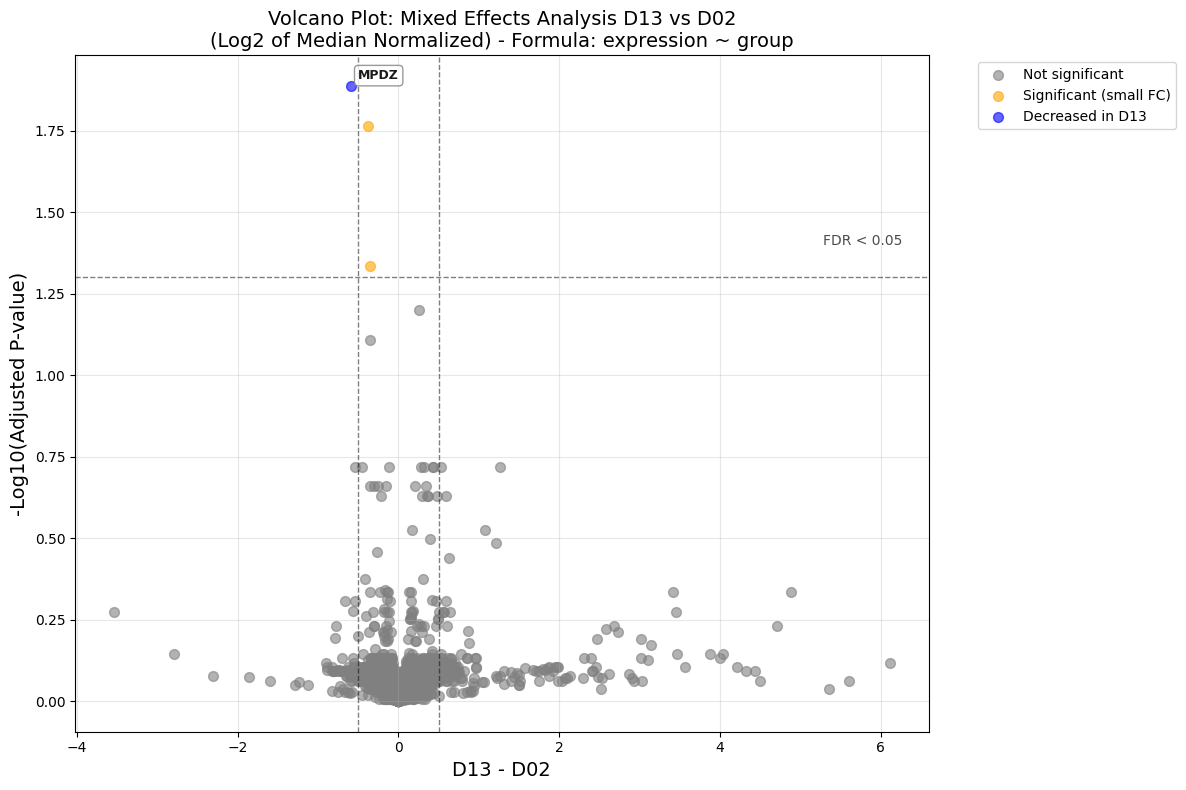

In [24]:
# Advanced Analysis Results Visualization
if adv_results_df is not None and len(adv_results_df) > 0:
    
    # Summary statistics
    print(f"\n=== ADVANCED DIFFERENTIAL ANALYSIS RESULTS ===\n")
    print(f"Analysis type: {adv_analysis_type.upper()} ({'GLM' if adv_analysis_type == 'unpaired' else 'Mixed Effects'})")
    print(f"Comparison: {adv_group2} vs {adv_group1} (reference)")
    print(f"Normalization: {adv_normalization_method.upper()} {adv_transform_label}")
    print(f"Model formula: {formula}")
    print(f"Total proteins analyzed: {len(adv_results_df)}")
    print(f"Significant proteins (FDR < {adv_p_threshold}): {adv_results_df['Significant'].sum()}")
    
    # Count up/down regulated
    adv_upregulated = ((adv_results_df['logFC'] > adv_fc_threshold) & (adv_results_df['adj.P.Val'] < adv_p_threshold)).sum()
    adv_downregulated = ((adv_results_df['logFC'] < -adv_fc_threshold) & (adv_results_df['adj.P.Val'] < adv_p_threshold)).sum()
    
    print(f"Increased in {adv_group2} (logFC > {adv_fc_threshold}, FDR < {adv_p_threshold}): {adv_upregulated}")
    print(f"Decreased in {adv_group2} (logFC < -{adv_fc_threshold}, FDR < {adv_p_threshold}): {adv_downregulated}")
    
    # Create volcano plot
    plt.figure(figsize=(12, 8))
    
    # Calculate -log10(adj.P.Val) for volcano plot
    adv_results_df['neg_log10_adjP'] = -np.log10(adv_results_df['adj.P.Val'])
    
    # Replace infinite values with a large number for plotting
    adv_max_neg_log10 = adv_results_df['neg_log10_adjP'][np.isfinite(adv_results_df['neg_log10_adjP'])].max()
    adv_results_df['neg_log10_adjP'] = adv_results_df['neg_log10_adjP'].replace([np.inf, -np.inf], adv_max_neg_log10 + 1)
    
    # Create color categories
    adv_colors = []
    for _, row in adv_results_df.iterrows():
        if row['adj.P.Val'] < adv_p_threshold and abs(row['logFC']) > adv_fc_threshold:
            if row['logFC'] > adv_fc_threshold:
                adv_colors.append('red')  # Increased
            else:
                adv_colors.append('blue')  # Decreased
        elif row['adj.P.Val'] < adv_p_threshold:
            adv_colors.append('orange')  # Significant but small fold change
        else:
            adv_colors.append('gray')  # Not significant
    
    adv_results_df['color'] = adv_colors
    
    # Create scatter plot
    for color in ['gray', 'orange', 'blue', 'red']:
        subset = adv_results_df[adv_results_df['color'] == color]
        if len(subset) > 0:
            label_map = {
                'gray': 'Not significant',
                'orange': 'Significant (small FC)',
                'blue': f'Decreased in {adv_group2}',
                'red': f'Increased in {adv_group2}'
            }
            plt.scatter(subset['logFC'], subset['neg_log10_adjP'], 
                       c=color, alpha=0.6, s=50, label=label_map[color])
    
    # Add threshold lines
    plt.axvline(x=adv_fc_threshold, color='black', linestyle='--', alpha=0.5, linewidth=1)
    plt.axvline(x=-adv_fc_threshold, color='black', linestyle='--', alpha=0.5, linewidth=1)
    plt.axhline(y=-np.log10(adv_p_threshold), color='black', linestyle='--', alpha=0.5, linewidth=1)
    
    # Add FDR threshold label
    plt.text(plt.xlim()[1] * 0.95, -np.log10(adv_p_threshold) + 0.1, f'FDR < {adv_p_threshold}', 
             ha='right', fontsize=10, alpha=0.7)
    
    plt.xlabel(f'{adv_group2} - {adv_group1}', fontsize=14)
    plt.ylabel('-Log10(Adjusted P-value)', fontsize=14)
    plt.title(f'Volcano Plot: {"GLM" if adv_analysis_type == "unpaired" else "Mixed Effects"} Analysis {adv_group2} vs {adv_group1}\n{adv_transform_label} - Formula: {formula}', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Annotate top significant proteins with gene names
    adv_significant_proteins = adv_results_df[
        (adv_results_df['adj.P.Val'] < adv_p_threshold) & 
        (abs(adv_results_df['logFC']) > adv_fc_threshold)
    ].nsmallest(10, 'adj.P.Val')
    
    for _, row in adv_significant_proteins.iterrows():
        # Use Gene name if available, otherwise fall back to Protein ID
        if 'Gene' in row and pd.notna(row['Gene']) and str(row['Gene']).strip() and str(row['Gene']) != str(row['Protein']):
            protein_label = str(row['Gene'])[:20]  # Use gene name, truncate to 20 chars
        else:
            protein_label = str(row['Protein'])[:15] if 'Protein' in row else 'Unknown'
        
        plt.annotate(protein_label, 
                    (row['logFC'], row['neg_log10_adjP']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, alpha=0.9, weight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='gray'))
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No advanced analysis results to display. Please check the analysis step.")

In [25]:
# Advanced Analysis Results Display and Export
if adv_results_df is not None and len(adv_results_df) > 0:
    
    print("\n" + "="*140)
    print(f"ADVANCED DIFFERENTIAL ANALYSIS RESULTS ({adv_normalization_method.upper()} NORMALIZED DATA)")
    print("="*140)
    
    # Prepare display columns - start with core columns and add annotations
    adv_base_display_cols = ['Protein_ID', 'Gene', 'Description', 'logFC', 'FC', 'AveExpr', 'SE', 'P.Value', 'adj.P.Val']
    
    # Build display columns dynamically based on what's available
    adv_display_cols = []
    
    # Add annotation columns in preferred order
    adv_preferred_order = ['Protein_ID', 'Gene', 'Description', 'UniProt_Accession']
    for col in adv_preferred_order:
        if col in adv_results_df.columns:
            adv_display_cols.append(col)
    
    # Add any other annotation columns we might have missed
    if 'annotation_columns' in globals():
        for col in annotation_columns:
            if col in adv_results_df.columns and col not in adv_display_cols:
                adv_display_cols.append(col)
    
    # Add statistical columns at the end
    adv_stat_cols = ['logFC', 'FC', 'AveExpr', 'SE', 'P.Value', 'adj.P.Val', 'n_group1', 'n_group2', 'n_total', 'model_type']
    for col in adv_stat_cols:
        if col in adv_results_df.columns:
            adv_display_cols.append(col)
    
    # Remove duplicates while preserving order
    adv_display_cols = list(dict.fromkeys(adv_display_cols))
    
    # Build full columns list for CSV output (includes all columns)
    adv_full_cols = []
    
    # Add annotation columns in preferred order (including all for CSV)
    adv_full_preferred_order = ['Protein_ID', 'Gene', 'Description', 'UniProt_Accession', 'UniProt_Database', 'UniProt_Entry_Name']
    for col in adv_full_preferred_order:
        if col in adv_results_df.columns:
            adv_full_cols.append(col)
    
    # Add any other annotation columns we might have missed
    if 'annotation_columns' in globals():
        for col in annotation_columns:
            if col in adv_results_df.columns and col not in adv_full_cols:
                adv_full_cols.append(col)
    
    # Add statistical columns at the end
    for col in adv_stat_cols:
        if col in adv_results_df.columns:
            adv_full_cols.append(col)
    
    # Remove duplicates while preserving order
    adv_full_cols = list(dict.fromkeys(adv_full_cols))
    
    print(f"Display columns: {adv_display_cols[:5]}{'...' if len(adv_display_cols) > 5 else ''} (total: {len(adv_display_cols)})")
    print(f"CSV output columns: {adv_full_cols[:5]}{'...' if len(adv_full_cols) > 5 else ''} (total: {len(adv_full_cols)})")
    
    # Top 20 increased proteins
    adv_top_up = adv_results_df[(adv_results_df['logFC'] > 0)].nsmallest(20, 'adj.P.Val')
    if len(adv_top_up) > 0:
        print(f"\nTOP 20 INCREASED PROTEINS IN {adv_group2} vs {adv_group1} ({'GLM' if adv_analysis_type == 'unpaired' else 'Mixed Effects'}):")
        print("="*140)
        
        # Print header with proper spacing
        print(f"{'Protein':<20} {'Gene':<12} {'Description':<40} {'logFC':<8} {'P.Value':<12} {'adj.P.Val':<12}")
        print("-" * 140)
        
        # Print each row with consistent formatting
        for _, row in adv_top_up.iterrows():
            protein_short = str(row['Protein_ID'])[:19] if 'Protein_ID' in row else str(row['Protein'])[:19]
            gene_short = str(row['Gene'])[:11] if 'Gene' in row and pd.notna(row['Gene']) else 'Unknown'
            desc_short = str(row['Description'])[:39] if 'Description' in row and pd.notna(row['Description']) else 'Unknown'
            
            print(f"{protein_short:<20} {gene_short:<12} {desc_short:<40} {row['logFC']:<8.3f} {row['P.Value']:<12.2e} {row['adj.P.Val']:<12.2e}")
    
    # Top 20 decreased proteins
    adv_top_down = adv_results_df[(adv_results_df['logFC'] < 0)].nsmallest(20, 'adj.P.Val')
    if len(adv_top_down) > 0:
        print(f"\nTOP 20 DECREASED PROTEINS IN {adv_group2} vs {adv_group1} ({'GLM' if adv_analysis_type == 'unpaired' else 'Mixed Effects'}):")
        print("="*140)
        
        # Print header with proper spacing
        print(f"{'Protein':<20} {'Gene':<12} {'Description':<40} {'logFC':<8} {'P.Value':<12} {'adj.P.Val':<12}")
        print("-" * 140)
        
        # Print each row with consistent formatting
        for _, row in adv_top_down.iterrows():
            protein_short = str(row['Protein_ID'])[:19] if 'Protein_ID' in row else str(row['Protein'])[:19]
            gene_short = str(row['Gene'])[:11] if 'Gene' in row and pd.notna(row['Gene']) else 'Unknown'
            desc_short = str(row['Description'])[:39] if 'Description' in row and pd.notna(row['Description']) else 'Unknown'
            
            print(f"{protein_short:<20} {gene_short:<12} {desc_short:<40} {row['logFC']:<8.3f} {row['P.Value']:<12.2e} {row['adj.P.Val']:<12.2e}")
    
    # Export results to CSV files
    print(f"\n=== EXPORTING ADVANCED ANALYSIS RESULTS ===")
    
    # Create filenames with analysis parameters
    adv_filename_base = f"advanced_differential_analysis_{adv_group2}_vs_{adv_group1}_{adv_normalization_method}_normalized"
    adv_output_filename = f"{adv_filename_base}.csv"
    adv_comprehensive_filename = f"{adv_filename_base}_ALL_PROTEINS.csv"
    
    # Top results (significant + top non-significant)
    adv_significant_results = adv_results_df[adv_results_df['Significant']]
    adv_top_nonsignificant = adv_results_df[~adv_results_df['Significant']].head(200)  # Top 200 non-significant
    adv_export_results = pd.concat([adv_significant_results, adv_top_nonsignificant]).sort_values('P.Value')
    
    try:
        adv_export_results[adv_display_cols].to_csv(adv_output_filename, index=False)
        print(f"✓ Top results saved to: {adv_output_filename}")
        print(f"  Rows: {len(adv_export_results)}")
        print(f"  Columns: {len(adv_display_cols)}")
    except Exception as e:
        print(f"✗ Error saving {adv_output_filename}: {e}")
    
    # Comprehensive results (all proteins with all columns)
    try:
        adv_results_df[adv_full_cols].to_csv(adv_comprehensive_filename, index=False)
        print(f"✓ Comprehensive results saved to: {adv_comprehensive_filename}")
        print(f"  Rows: {len(adv_results_df)}")
        print(f"  Columns: {len(adv_full_cols)}")
    except Exception as e:
        print(f"✗ Error saving {adv_comprehensive_filename}: {e}")
    
    print(f"\nResults saved to two files:")
    print(f"1. {adv_output_filename} - Top results shown in tables above")
    print(f"2. {adv_comprehensive_filename} - ALL {len(adv_results_df)} proteins sorted by significance")
    
    print(f"\n" + "="*140)
    print(f"ADVANCED ANALYSIS SUMMARY:")
    print(f"Results saved to:")
    print(f"  • {adv_output_filename} - Top results (displayed above)")
    print(f"  • {adv_comprehensive_filename} - ALL proteins sorted by significance")
    print(f"Analysis type: {adv_analysis_type.upper()} ({'GLM' if adv_analysis_type == 'unpaired' else 'Mixed Effects'})")
    print(f"Model formula: {formula}")
    print(f"Comparison: {adv_group2} vs {adv_group1} (reference)")
    print(f"Normalization: {adv_normalization_method.upper()} {adv_transform_label}")
    print(f"Log2 FC threshold: ±{adv_fc_threshold} (fold change: {2**adv_fc_threshold:.2f})")
    print(f"Adjusted p-value threshold: {adv_p_threshold}")
    print(f"Total proteins: {len(adv_results_df)}")
    if 'model_type' in adv_results_df.columns:
        print(f"Model type: {adv_results_df['model_type'].iloc[0]}")
    print(f"Significant proteins: {adv_results_df['Significant'].sum()}")
    print(f"Increased: {adv_upregulated}")
    print(f"Decreased: {adv_downregulated}")
    print(f"Additional covariates: {adv_additional_covariates if adv_additional_covariates else 'None'}")
    print("="*140)
    
else:
    print("No advanced analysis results available to display.")


ADVANCED DIFFERENTIAL ANALYSIS RESULTS (MEDIAN NORMALIZED DATA)
Display columns: ['Protein_ID', 'Gene', 'Description', 'UniProt_Accession', 'Protein']... (total: 15)
CSV output columns: ['Protein_ID', 'Gene', 'Description', 'UniProt_Accession', 'Protein']... (total: 15)

TOP 20 INCREASED PROTEINS IN D13 vs D02 (Mixed Effects):
Protein              Gene         Description                              logFC    P.Value      adj.P.Val   
--------------------------------------------------------------------------------------------------------------------------------------------
sp|Q6XQN6|PNCB_HUMA  NAPRT        Nicotinate phosphoribosyltransferase     0.259    7.49e-05     6.33e-02    
sp|Q9UL46|PSME2_HUM  PSME2        Proteasome activator complex subunit 2   0.433    4.14e-04     1.91e-01    
sp|Q6GTS8|P20D1_HUM  PM20D1       N-fatty-acyl-amino acid synthase/hydrol  0.428    4.72e-04     1.91e-01    
sp|Q8IZJ1|UNC5B_HUM  UNC5B        Netrin receptor UNC5B                    0.281    5.45e